# NeuroData processing

In [416]:
# %matplotlib inline
# %load_ext autotime

In [1]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [2]:
mouse = '3C280'
Session = 45
active_blocks = [1,2,3,5,6]
# active_blocks = [1,2,4,5]

### Ephys data

In [3]:
# KSdir = "C:\\Users\\teamROUXadmin\\Desktop\\Eva\\msc data\\home\\s45\\"
KSdir = f"D:\\{mouse}_S{Session}\\Kilosort_2024-04-12_162032\\"

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix

# probefile = KSdir+"probe.pkl"
# probe = pkl.load(open(probefile,'rb'))
# channelmapfile = KSdir+"channel_map.npy"
# cmap = np.load(channelmapfile)
# channelposfile = KSdir+"channel_positions.npy"
# cpos = np.load(channelposfile)

# wavefile = KSdir+"_phy_spikes_subset.waveforms.npy"
# spikewaves = np.load(wavefile)
# wavesubsetfile = KSdir+"_phy_spikes_subset.spikes.npy"
# spikewavesubsets = np.load(wavesubsetfile)
# wavesubsetchannelfile = KSdir+"_phy_spikes_subset.channels.npy"
# spikewavesubsetchannels = np.load(wavesubsetchannelfile)

# KSClusterinfofile = KSdir+"cluster_KSLabel.tsv"
# KSClusterinfo = pd.read_csv(KSClusterinfofile,sep='\t')

In [4]:
spiketimes, spiketimes.shape

(array([[      492],
        [     1638],
        [     1855],
        ...,
        [185399226],
        [185399227],
        [185399265]], dtype=uint64),
 (1425035, 1))

In [5]:
spikeclusters, spikeclusters.shape

(array([915,  37,  37, ..., 871,  18, 869]), (1425035,))

In [6]:
Clusterinfo

,cluster_id,amp,ch,depth,fr,group,n_spikes,sh
0,1,96.321930,28,-60.0,6.990426,good,64801,5.0
1,2,56.537376,15,-40.0,0.108091,noise,1002,6.0
2,3,85.268417,7,-60.0,0.032686,noise,303,6.0
3,4,39.368500,38,-60.0,0.090184,noise,836,3.0
4,5,38.116871,38,-60.0,0.049946,noise,463,3.0
...,...,...,...,...,...,...,...,...
231,914,41.682297,41,-140.0,0.008091,noise,75,3.0
232,915,41.355259,37,-20.0,3.072504,good,28482,3.0
233,916,41.355259,37,-20.0,0.007983,noise,74,3.0
234,917,35.598309,42,-180.0,3.375957,good,31295,3.0


In [4]:
### gets clusters labelled "good" and then translates it into a list called "goods"

goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
## pandas.Series: | cluster_idx | cluster_id |

goods = [] # list of good cluster_id
for clust in goodclusts :
    goods.append(clust)
print(f'In session {Session} we have {len(goods)} good clusters')

In session 45 we have 24 good clusters


In [5]:
### extracts spike times on a per unit basis for the "goods"
goodspiketimes = {}
spikethresh = 1000 # at least defined nb of spikes (if less, it's a piece of shit)

for goodunit in goods : # iterate by good units
    # spike indeces of this good unit
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : # at least defined nb of spikes
        goodspiketimes[goodunit] = spiketimes[goodinds]
        print(f'unit {goodunit} --------', f'# of spikes {goodspiketimes[goodunit].shape[0]}')

unit 1 -------- # of spikes 64801
unit 18 -------- # of spikes 108946
unit 53 -------- # of spikes 95509
unit 594 -------- # of spikes 171730
unit 596 -------- # of spikes 47158
unit 861 -------- # of spikes 53611
unit 869 -------- # of spikes 239764
unit 870 -------- # of spikes 80089
unit 871 -------- # of spikes 74658
unit 874 -------- # of spikes 11729
unit 875 -------- # of spikes 2085
unit 877 -------- # of spikes 2186
unit 889 -------- # of spikes 8876
unit 890 -------- # of spikes 2649
unit 892 -------- # of spikes 3165
unit 893 -------- # of spikes 3893
unit 895 -------- # of spikes 4634
unit 897 -------- # of spikes 4899
unit 905 -------- # of spikes 13863
unit 909 -------- # of spikes 14307
unit 911 -------- # of spikes 19398
unit 913 -------- # of spikes 27622
unit 915 -------- # of spikes 28482
unit 917 -------- # of spikes 31295


In [6]:
goodspiketimes

{1: array([[  1602495],
        [  1668702],
        [  7682038],
        ...,
        [185390764],
        [185391015],
        [185391363]], dtype=uint64),
 18: array([[     9714],
        [     9972],
        [    10327],
        ...,
        [185398991],
        [185399141],
        [185399227]], dtype=uint64),
 53: array([[     4335],
        [     5561],
        [     9254],
        ...,
        [185386413],
        [185388747],
        [185390135]], dtype=uint64),
 594: array([[   304019],
        [   366884],
        [   540888],
        ...,
        [185398450],
        [185398547],
        [185399159]], dtype=uint64),
 596: array([[    24157],
        [    24497],
        [    25371],
        ...,
        [185396487],
        [185397048],
        [185397218]], dtype=uint64),
 861: array([[     2270],
        [     9440],
        [    11877],
        ...,
        [185397295],
        [185398829],
        [185399169]], dtype=uint64),
 869: array([[    11559],
        [    13489

In [10]:
len(goodspiketimes.keys())

24

In [18]:
goods

[1,
 18,
 53,
 594,
 596,
 861,
 869,
 870,
 871,
 874,
 875,
 877,
 889,
 890,
 892,
 893,
 895,
 897,
 905,
 909,
 911,
 913,
 915,
 917]

### Behavior data

In [7]:
### 17 interesting behavioral events... giulio's matlab function!
matfile = f"D:\\{mouse}_S{Session}\\Behaviour.mat"
EvaBehavior = loadmat(matfile)

For S38:

* `EvaBehavior['Behaviour'][0]` - home cage
* `EvaBehavior['Behaviour'][1]` - alpha
* `EvaBehavior['Behaviour'][2]` - beta
* `EvaBehavior['Behaviour'][3]` - home cage
* `EvaBehavior['Behaviour'][4]` - alpha
* `EvaBehavior['Behaviour'][5]` - beta

For S46:
* `EvaBehavior['Behaviour'][0]` - home cage
* `EvaBehavior['Behaviour'][1]` - alpha
* `EvaBehavior['Behaviour'][2]` - beta
* `EvaBehavior['Behaviour'][3]` - blank
* `EvaBehavior['Behaviour'][4]` - home cage
* `EvaBehavior['Behaviour'][5]` - alpha
* `EvaBehavior['Behaviour'][6]` - beta

In [8]:
# Let's see what behavior events we have
shapes = []
for i in range(len(EvaBehavior['Behaviour'][0])):
    try:
        shapes.append(EvaBehavior['Behaviour'][1][i].shape)
    except:
        shapes.append(EvaBehavior['Behaviour'][1][i])
df = pd.DataFrame({'Behavior Event Names': EvaBehavior['Behaviour'].dtype.names, 'Shape': shapes})
df

,Behavior Event Names,Shape
0,MinimumDurationSocialPoke,250
1,StartTrial,"(30,)"
2,EndTrial,"(30,)"
3,TrialWindow,"(30, 2)"
4,IntanSent,"(44,)"
5,IntanSynchTriggers,"(44, 2)"
6,VisitingSocialSamplingTriggers,"(64, 2)"
7,TestSocialSamplingTriggers,"(116, 2)"
8,WithinTrialTestSocialSamplingTriggers,"(116,)"
9,WhichTrialTestSocialSamplingTriggers,"(116,)"


In [9]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [10]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12) # 250 ms nosepokes onset|offset
VisitingSocialSamplingTriggers = load_behavioral_event(6) # all vis mouse npokes onset|offset
TestSocialSamplingTriggers = load_behavioral_event(7) # all test mouse npokes onset|offset (not only 250 ms)

TestSocialSampleOnsetPerTrial = load_behavioral_event(10)
TestSocialSampleOffsetPerTrial = load_behavioral_event(11)

## Npoke analysis

In [17]:
# check window duration
(TestSocialSampleWindowPerTrial[1][:,1]-TestSocialSampleWindowPerTrial[1][:,0])/20000

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

In [18]:
(TestSocialSampleOffsetPerTrial[1]-TestSocialSampleOnsetPerTrial[1])/20000

array([0.3188 , 0.27035, 0.3953 , 0.43515, 0.30195, 0.3907 , 0.38855,
       0.2665 , 0.27885, 0.39755, 0.3762 , 0.39095, 0.44805, 0.4473 ,
       0.5612 , 0.29725, 0.2853 , 0.3063 , 0.3498 , 0.38405, 0.29355,
       0.4237 , 0.50335, 0.3978 , 0.32735, 0.3251 , 0.42695, 0.36915,
       0.257  , 0.4179 ])

In [11]:
# dic with info about reciprocal npokes
reciprocal_npokes = {}

for block in active_blocks:
    reciprocal_np = np.zeros(len(TestSocialSampleWindowPerTrial[block]))
    cnt=0
    for event1 in TestSocialSampleWindowPerTrial[block]:
        for event2 in VisitingSocialSamplingTriggers[block]:
            cond1 = (event2[0] <= event1[0] and event2[1] >= event1[0])
            cond2 = event1[1]>=event2[0]>=event1[0]
            if cond1 or cond2:
                reciprocal_np[cnt]=1
        cnt+=1
    reciprocal_npokes[block] = reciprocal_np

In [20]:
for block in active_blocks:
    print(f'Block {block}: ',np.sum(reciprocal_npokes[block]), '\n' ,reciprocal_npokes[block])

Block 1:  1.0 
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Block 2:  1.0 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0.]
Block 3:  0.0 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Block 5:  6.0 
 [0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.]
Block 6:  2.0 
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Trial neuronal activity. Identifying of good units

In [12]:
## find spikes in interesting behavioral window
beforesamples = 20000 # 5000/20000=0.250 sec
aftersamples = 20000 # 1 sec
eventlength = 5000 # 0.25 s

# for psth
binsize = 1000 ### 50 ms expressed in samples for a 20khz sampling rate
bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

blocks = active_blocks

spikes_dic = {}
psth_dic = {}

for block in blocks:
    blockdic = {}
    unitspikes = {}
    eventhists = {}

    for unit in goodspiketimes.keys(): # list of good cluster_id

        unitspikes[unit] = {}
        eventhists[unit] = np.zeros(bins.shape[0]-1)

        for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

            onset = TestSocialSampleWindowPerTrial[block][event,0]
            offset = TestSocialSampleWindowPerTrial[block][event,1] # for s36: -(0.25*20000) # since window is 500 for some reason
            
            cond1 = np.where(goodspiketimes[unit].astype(int)>=onset-beforesamples)[0]
            cond2 = np.where(goodspiketimes[unit].astype(int)<=offset+aftersamples)[0]
            unitspikes[unit][event] = goodspiketimes[unit][np.intersect1d(cond1,cond2)].astype(int)-onset
            
            # PSTH
            n = np.histogram(unitspikes[unit][event], bins=bins)
            eventhists[unit]+=n[0]
               
    spikes_dic[block] = unitspikes
    psth_dic[block] = eventhists

In [22]:
psth_dic

{1: {1: array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 2., 0., 1.,
         1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 4., 3., 3.,
         0., 1., 0., 2., 1., 2., 1., 1., 2., 1., 0.]),
  18: array([17., 14., 26., 29., 21., 38., 47., 36., 37., 21., 15., 22., 37.,
         35., 68., 30., 27., 19., 15., 16., 60., 45., 16., 22., 17., 10.,
          1.,  2.,  3.,  5.,  8.,  5., 15.,  9., 11., 20., 13., 12.,  4.,
          1.,  4.,  4.,  6.,  3.,  6.]),
  53: array([14.,  7., 13.,  9., 14., 13., 12., 12., 13., 15.,  9., 17.,  8.,
         11.,  9., 13., 14.,  6., 13., 10., 15.,  6., 11., 11., 11., 11.,
         11.,  6.,  6., 10., 11., 16., 14., 12., 13., 15., 15., 17.,  8.,
         13.,  9.,  8.,  7.,  6.,  0.]),
  594: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  596: array([ 6.,  2.,  8.,  3.,  7.

In [23]:
def event_raster(block, reciprocal=False):
    if reciprocal:
        event_idx_list = np.where(reciprocal_npokes[block] ==1)[0]
    else:
        event_idx_list = np.arange(TestSocialSampleWindowPerTrial[block].shape[0])

    for event in event_idx_list :
        offset=0
        plt.figure(figsize=(4, 4))
        for unit in goodspiketimes.keys() : # we have 30 good units with firing rate>1000
            plt.vlines(list(spikes_dic[block][unit][event]),offset,offset+1, color='black', alpha=0.5)
            offset+=1
        # norm_psth = (eventhists[unit] - np.mean(eventhists[unit])) / np.std(eventhists[unit])
        # Min-Max normalization
        
        plt.axvline(0, color='red', alpha=0.3)
        plt.axvline(eventlength, color='red', alpha=0.3)
        plt.xlim([-5000,10000])
        plt.ylim([-1,len(goodspiketimes.keys())+1])
        plt.title(f'Session {38}, Block {1}, Npoke event {event+1}', fontsize=10)
        plt.xlabel('Time, sec',  fontsize=9)
        plt.xticks(bins[::5], labels=bins[::5]/20000, fontsize=7)
        plt.yticks([x for x in range(len(list(goodspiketimes.keys())))], labels=list(goodspiketimes.keys()), fontsize=7)
        plt.ylabel('Neuronal unit',  fontsize=9)
        plt.show()


In [448]:
#event_raster(1, reciprocal=False)

### Unit psth

In [13]:
# sort neurons by Alpha block
block=1 #alpha

# window for sorting
start = int((beforesamples/binsize)-1) # beginning of nosepoke
afternp = 5000 # 0.250 s after the end of the nosepoke event
end = int((beforesamples+eventlength+afternp)/binsize)


neuron_means = {unit: np.mean(psth_dic[block][unit][start:end]) for unit in psth_dic[block]}
sorted_neurons = sorted(neuron_means.items(), key=lambda x: x[1], reverse=True)
neuron_ids = [neuron[0] for neuron in sorted_neurons]

In [25]:
from matplotlib.colors import LinearSegmentedColormap

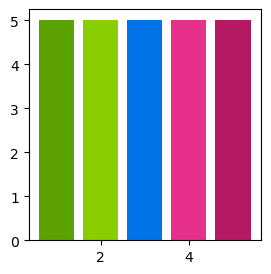

In [14]:
palette_initial = ['#5ba300', '#89ce00', '#0073e6', '#e6308a', '#b51963']
palette = ['#5ba300', '#89ce00', '#0073e6', '#e6308a', '#b51963']

x = [1, 2, 3, 4, 5]
y = [5,5,5,5,5]

plt.figure(figsize=(3, 3))
for i in range(5):
    plt.bar(x[i], y[i], color = palette_initial[i])  # Set alpha for transparency

plt.show()

In [15]:
def psth_trial_activity(blocks):
    
    if len(blocks) ==4:
        palette = ['#5ba300', '#b51963', '#89ce00', '#e6308a']
    else:
        palette = ['#5ba300', '#b51963', '#0073e6', '#89ce00', '#e6308a']

    # sort neurons by the first block in blocks
    block=blocks[0]
    ## window for sorting
    start = int((beforesamples/binsize)-1) # beginning of nosepoke
    afternp = 5000 # 250 ms after the end of the nosepoke event
    end = int((beforesamples+eventlength+afternp)/binsize)
    ## sorting
    neuron_means = {unit: np.mean(psth_dic[block][unit][start:end]) for unit in psth_dic[block]}
    sorted_neurons = sorted(neuron_means.items(), key=lambda x: x[1], reverse=True)
    neuron_ids = [neuron[0] for neuron in sorted_neurons]

    # prepare data
    bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

    firing_rates = {}
    for block in blocks:
        firing_rates[block] = [psth_dic[block][neuron_id] for neuron_id in neuron_ids]
    
    # Define a custom colormap going from white to black
    from matplotlib.colors import LinearSegmentedColormap
    colors = [(1, 1, 1), (0, 0, 0)]  # white to black
    cmap_name = 'white_black'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

    if len(active_blocks)==4:
        plt.figure(figsize=(8, 3))
    else:
        plt.figure(figsize=(10, 3))
    x = len(blocks)

    # 1 block
    plt.subplot(1, x+1, 1)
    plt.imshow(firing_rates[1], cmap=cm, aspect='auto')
    plt.title('Block 1')
    plt.xlabel('Time (s)')
    plt.ylabel('Cell number (sorted)')
    plt.yticks(np.arange(len(neuron_ids)), neuron_ids, fontsize=6)
    plt.xticks(list(range(0, len(bins)+1, 5)), labels=bins[::5]/20000, fontsize=6, rotation=45)
    plt.axvspan(beforesamples/binsize, (beforesamples+eventlength)/binsize, color=palette[0], alpha=0.03)
    plt.axvline(x=beforesamples/binsize, color=palette[0], linewidth=0.5)
    plt.axvline(x=(beforesamples+eventlength)/binsize, color=palette[0], linewidth=0.5)


    for i in range(1,x):
        plt.subplot(1, x+1, i+1)
        plt.imshow(firing_rates[blocks[i]], cmap=cm, aspect='auto')
        plt.title(f'Block {blocks[i]}')
        plt.xlabel('Time (s)')
        plt.ylabel('')
        plt.gca().set_yticklabels([])
        plt.xticks(list(range(0, len(bins)+1, 5)), labels=bins[::5]/20000, fontsize=6, rotation=45)
        plt.axvspan(beforesamples/binsize, (beforesamples+eventlength)/binsize, color=palette[i], alpha=0.03)
        plt.axvline(x=beforesamples/binsize, color=palette[i], linewidth=0.5)
        plt.axvline(x=(beforesamples+eventlength)/binsize, color=palette[i], linewidth=0.5)


    # FILLER BLOCK  
    plt.subplot(1, x+1, x+1)
    plt.imshow(firing_rates[1], cmap=cm, aspect='auto')
    plt.title('O_o')
    plt.gca().set_yticklabels([])
    cbar = plt.colorbar()
    cbar.set_label('Firing Rate [Hz]')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\single_cell_anal\\{mouse}_S{Session}_psth_trial_activity.png', dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

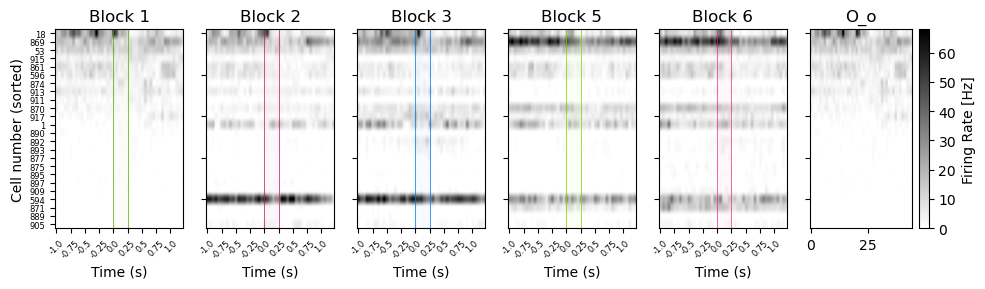

In [16]:
psth_trial_activity(active_blocks)

In [166]:
fav_cells = [687, 690, 617]

In [167]:
neuron_ids

[687, 615, 690, 617, 627, 695, 651, 344, 667, 679, 645, 683, 49]

## Activity of the best neurons in different trials

In [55]:
def best_cell_trial_activity(cell, blocks):
    unit = cell

    # prepare data
    bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

    if len(blocks) ==4:
        palette = ['#5ba300', '#b51963', '#89ce00', '#e6308a']
        figsize=(9, 3)
        x_morning = 3
        x_evening = 3
    else:
        palette = ['#5ba300', '#b51963', '#0073e6', '#89ce00', '#e6308a']
        figsize=(6, 5)
        x_morning = 3
        x_evening = 2

    plt.figure(figsize=figsize)

    ########################################
    # 1 block
    plt.subplot(2, x_morning, 1)
    offset=0
    event_idx_list = np.arange(TestSocialSampleWindowPerTrial[blocks[0]].shape[0])
    for event in event_idx_list :
        plt.vlines(list(spikes_dic[blocks[0]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        plt.vlines(list(spikes_dic[blocks[0]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        offset+=1
        
    # Min-Max normalization
    psth_minmax = (psth_dic[blocks[0]][unit] - np.min(psth_dic[blocks[0]][unit])) / (np.max(psth_dic[blocks[0]][unit]) - np.min(psth_dic[blocks[0]][unit]))
    plt.plot((bins[1:]+bins[:-1])/2, psth_minmax*5, color='black')
    plt.axvspan(0, eventlength, color = palette[0], alpha=0.2)
    plt.title(f'Block {blocks[0]}', fontsize=10)
    plt.xlabel('')
    plt.xticks(bins[::5], labels=bins[::5]/20000, fontsize=6, rotation=45)
    plt.yticks(fontsize=6)
    plt.ylabel('Trial',  fontsize=10)


    for i in range(1,3):
        plt.subplot(2, x_morning, i+1)
        offset=0
        event_idx_list = np.arange(TestSocialSampleWindowPerTrial[blocks[i]].shape[0])
        for event in event_idx_list :
            plt.vlines(list(spikes_dic[blocks[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
            plt.vlines(list(spikes_dic[blocks[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
            offset+=1
            
        # Min-Max normalization
        psth_minmax = (psth_dic[blocks[i]][unit] - np.min(psth_dic[blocks[i]][unit])) / (np.max(psth_dic[blocks[i]][unit]) - np.min(psth_dic[blocks[i]][unit]))
        plt.plot((bins[1:]+bins[:-1])/2, psth_minmax*5, color='black')
        plt.axvspan(0, eventlength, color = palette[i], alpha=0.2)
        plt.title(f'Block {blocks[i]}', fontsize=10)
        plt.xlabel('')
        plt.xticks(bins[::5], labels=bins[::5]/20000, fontsize=6, rotation=45)
        plt.ylabel('')
        plt.gca().set_yticklabels([])

    ########################################
    # 4 block
    plt.subplot(2, x_morning, 4)
    offset=0
    event_idx_list = np.arange(TestSocialSampleWindowPerTrial[blocks[3]].shape[0])
    for event in event_idx_list :
        plt.vlines(list(spikes_dic[blocks[3]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        plt.vlines(list(spikes_dic[blocks[3]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        offset+=1
        
    # Min-Max normalization
    psth_minmax = (psth_dic[blocks[3]][unit] - np.min(psth_dic[blocks[3]][unit])) / (np.max(psth_dic[blocks[3]][unit]) - np.min(psth_dic[blocks[3]][unit]))
    plt.plot((bins[1:]+bins[:-1])/2, psth_minmax*5, color='black')
    plt.axvspan(0, eventlength, color = palette[3], alpha=0.2)
    plt.title(f'Block {blocks[3]}', fontsize=10)
    plt.xlabel('Time, s',  fontsize=10)
    plt.xticks(bins[::5], labels=bins[::5]/20000, fontsize=6, rotation=45)
    plt.yticks(fontsize=6)
    plt.ylabel('Trial',  fontsize=10)

    # 5 block
    i = 4
    plt.subplot(2, x_morning, i+1)
    offset=0
    event_idx_list = np.arange(TestSocialSampleWindowPerTrial[blocks[i]].shape[0])
    for event in event_idx_list :
        plt.vlines(list(spikes_dic[blocks[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        plt.vlines(list(spikes_dic[blocks[i]][unit][event]),offset,offset+1, color='black', alpha=0.1)
        offset+=1
        
    # Min-Max normalization
    psth_minmax = (psth_dic[blocks[i]][unit] - np.min(psth_dic[blocks[i]][unit])) / (np.max(psth_dic[blocks[i]][unit]) - np.min(psth_dic[blocks[i]][unit]))
    plt.plot((bins[1:]+bins[:-1])/2, psth_minmax*5, color='black')
    plt.axvspan(0, eventlength, color = palette[i], alpha=0.2)
    plt.title(f'Block {blocks[i]}', fontsize=10)
    plt.xlabel('Time, s',  fontsize=10)
    plt.xticks(bins[::5], labels=bins[::5]/20000, fontsize=6, rotation=45)
    plt.ylabel('')
    plt.gca().set_yticklabels([])

    #############################################

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Add a title to the entire figure at the left-upper corner
    plt.suptitle(f"Cell {unit}", x=0.05, y=0.99, fontsize=12)

    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\single_cell_anal\\{mouse}_S{Session}_cell{unit}.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()


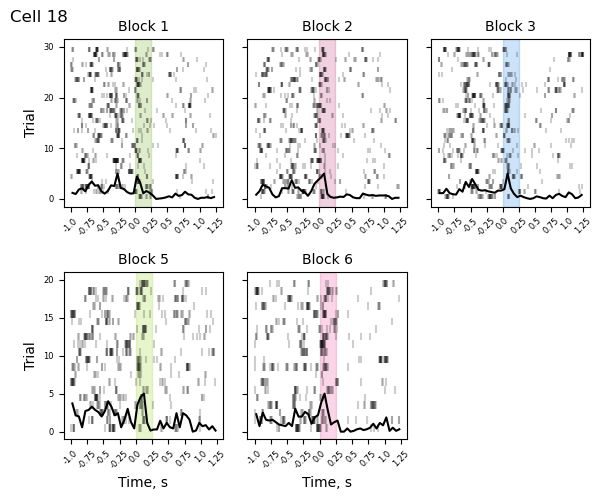

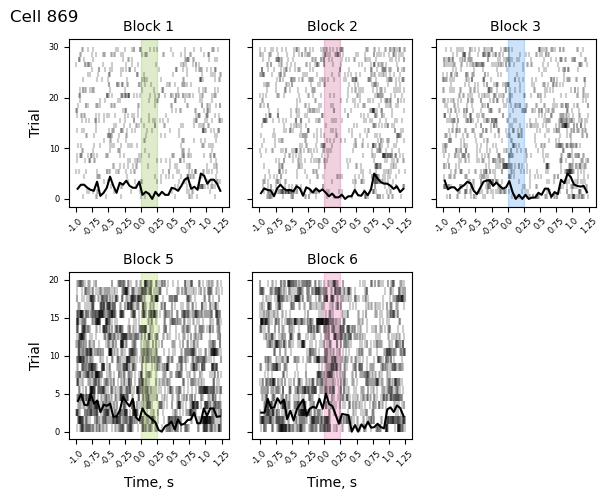

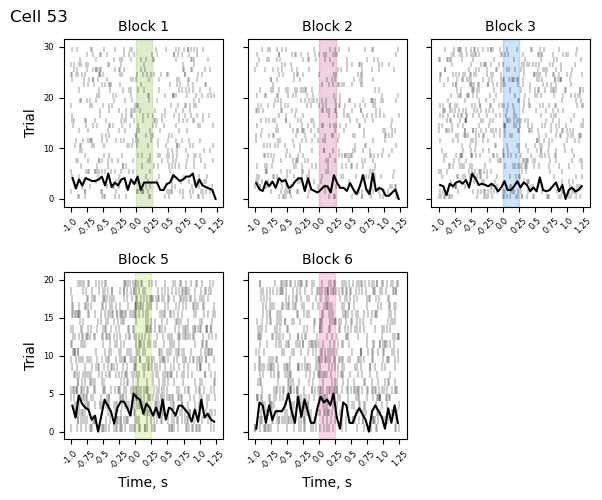

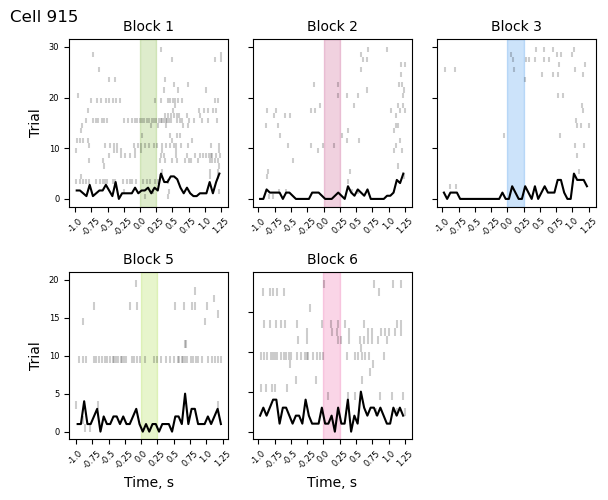

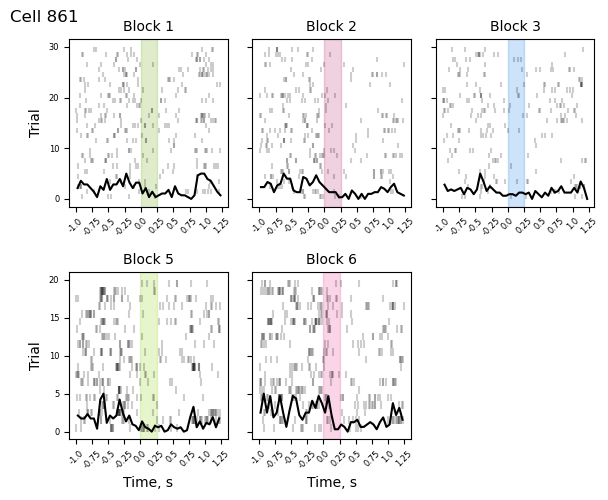

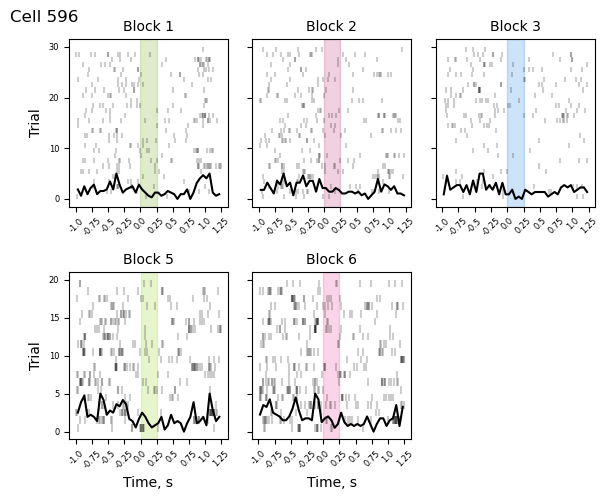

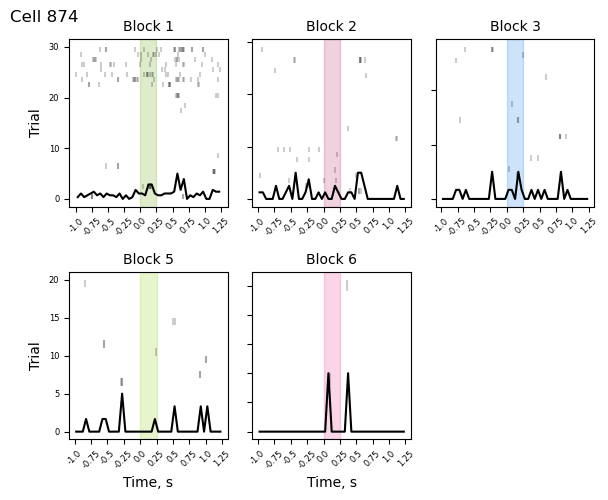

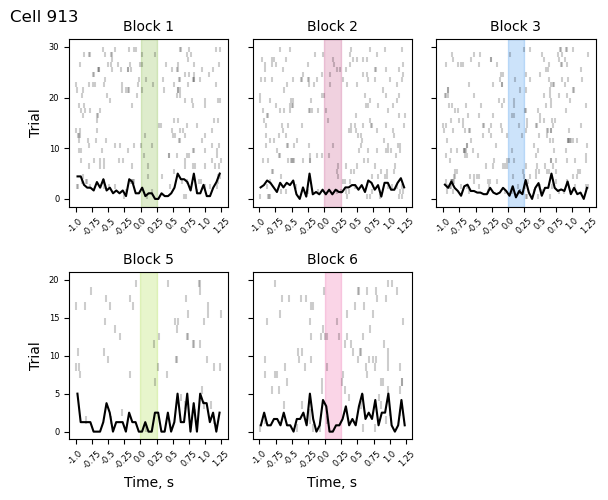

C:\Users\ebukina\AppData\Local\Temp\ipykernel_12884\877310282.py:51: RuntimeWarning: invalid value encountered in divide
  psth_minmax = (psth_dic[blocks[i]][unit] - np.min(psth_dic[blocks[i]][unit])) / (np.max(psth_dic[blocks[i]][unit]) - np.min(psth_dic[blocks[i]][unit]))


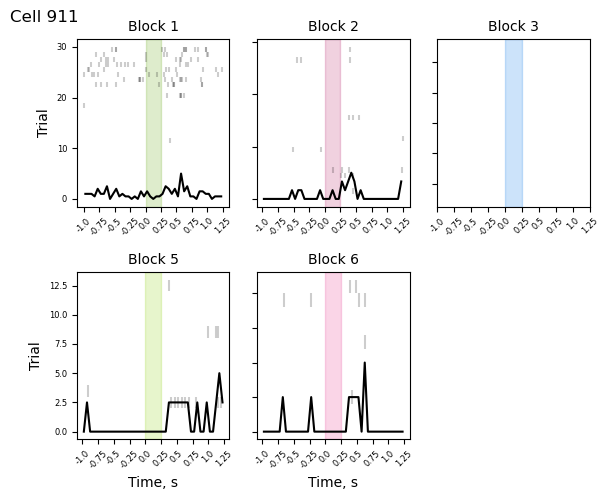

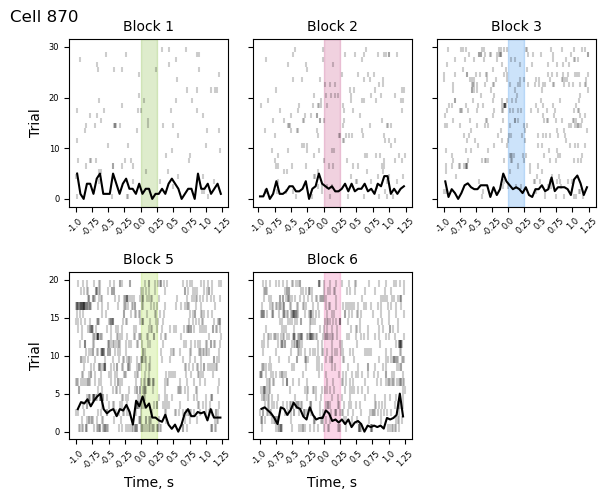

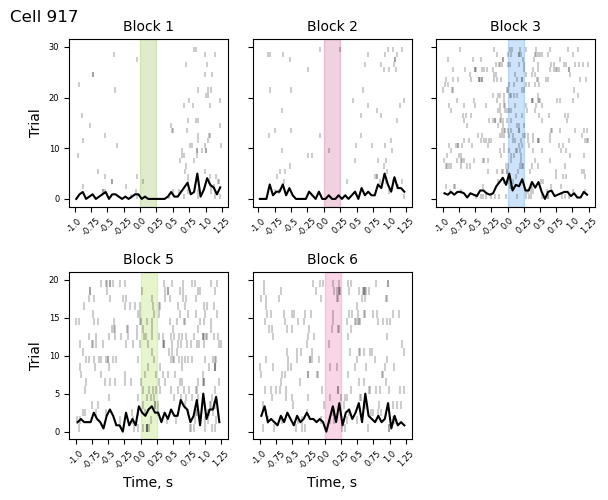

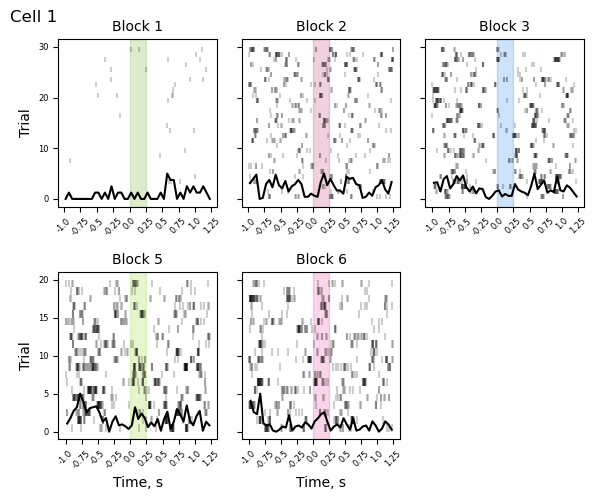

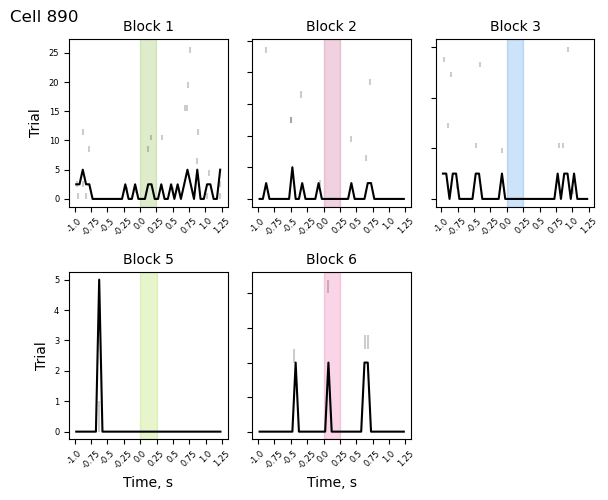

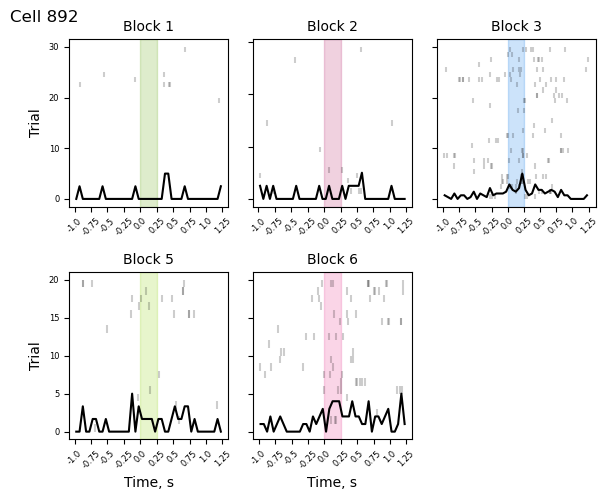

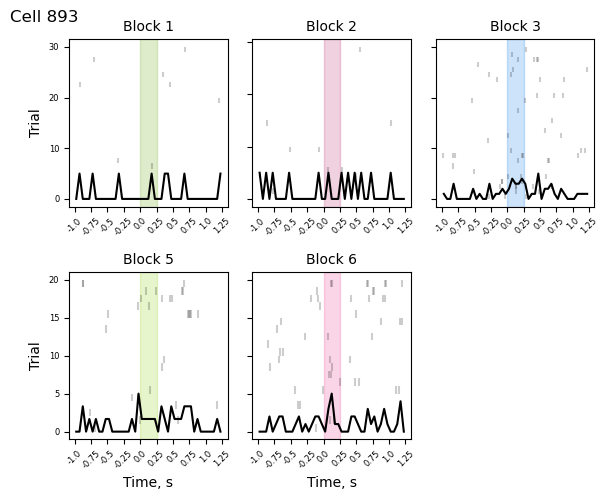

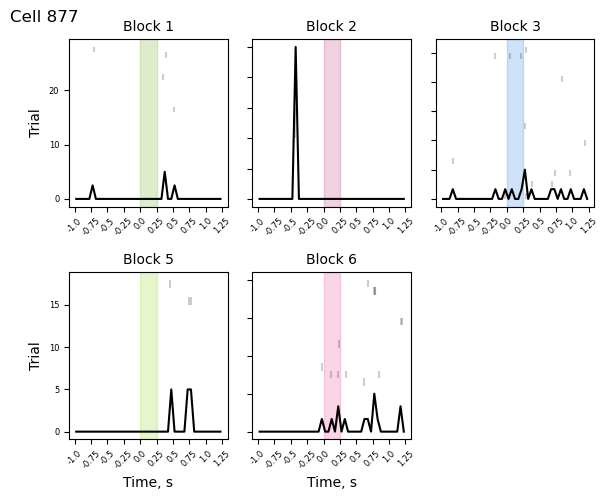

C:\Users\ebukina\AppData\Local\Temp\ipykernel_12884\877310282.py:51: RuntimeWarning: invalid value encountered in divide
  psth_minmax = (psth_dic[blocks[i]][unit] - np.min(psth_dic[blocks[i]][unit])) / (np.max(psth_dic[blocks[i]][unit]) - np.min(psth_dic[blocks[i]][unit]))
C:\Users\ebukina\AppData\Local\Temp\ipykernel_12884\877310282.py:71: RuntimeWarning: invalid value encountered in divide
  psth_minmax = (psth_dic[blocks[3]][unit] - np.min(psth_dic[blocks[3]][unit])) / (np.max(psth_dic[blocks[3]][unit]) - np.min(psth_dic[blocks[3]][unit]))


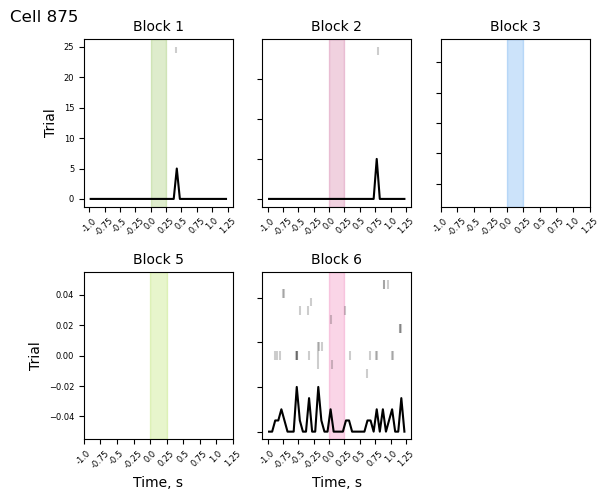

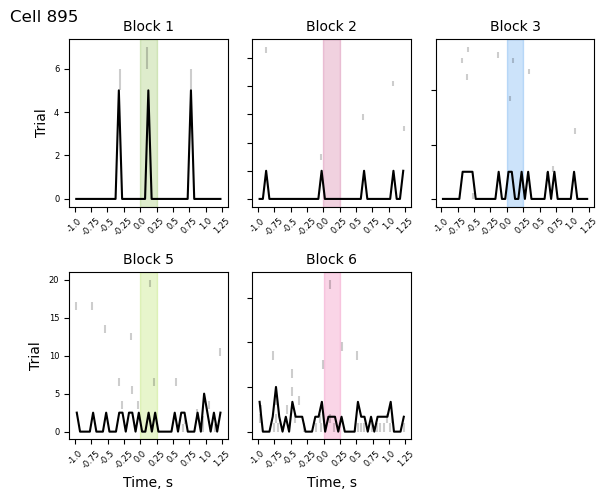

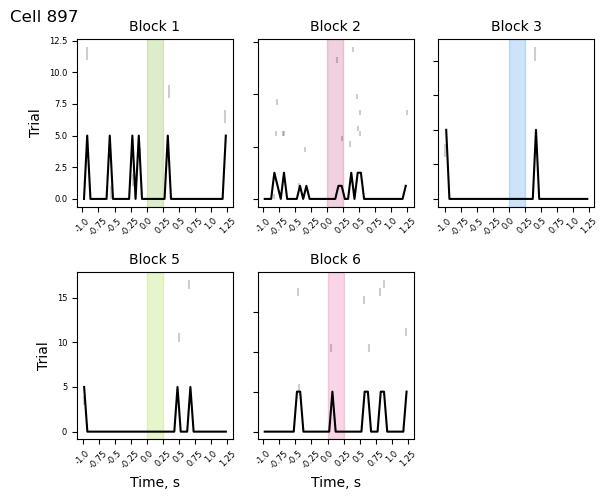

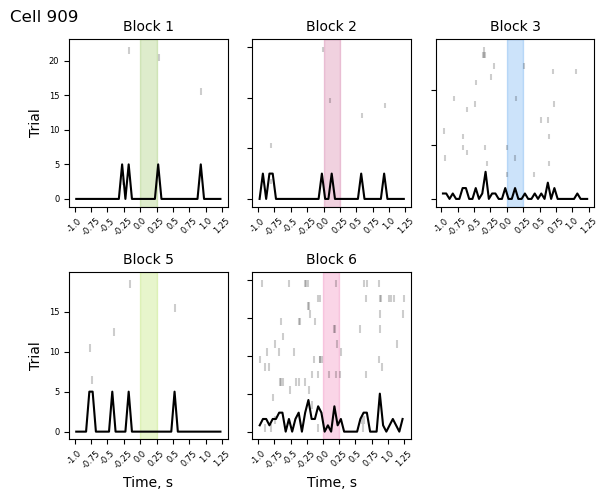

C:\Users\ebukina\AppData\Local\Temp\ipykernel_12884\877310282.py:31: RuntimeWarning: invalid value encountered in divide
  psth_minmax = (psth_dic[blocks[0]][unit] - np.min(psth_dic[blocks[0]][unit])) / (np.max(psth_dic[blocks[0]][unit]) - np.min(psth_dic[blocks[0]][unit]))


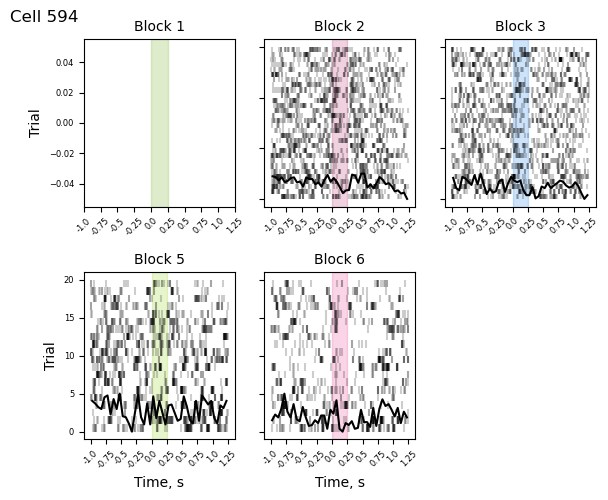

C:\Users\ebukina\AppData\Local\Temp\ipykernel_12884\877310282.py:31: RuntimeWarning: invalid value encountered in divide
  psth_minmax = (psth_dic[blocks[0]][unit] - np.min(psth_dic[blocks[0]][unit])) / (np.max(psth_dic[blocks[0]][unit]) - np.min(psth_dic[blocks[0]][unit]))


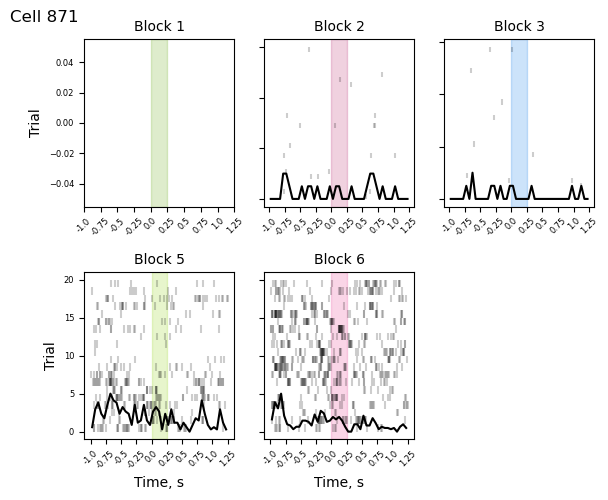

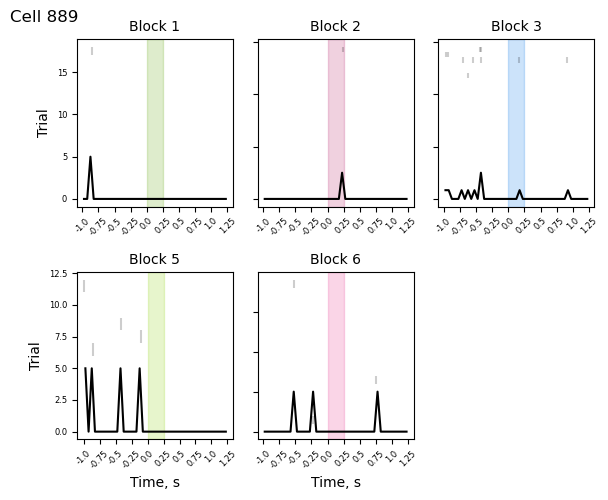

C:\Users\ebukina\AppData\Local\Temp\ipykernel_12884\877310282.py:31: RuntimeWarning: invalid value encountered in divide
  psth_minmax = (psth_dic[blocks[0]][unit] - np.min(psth_dic[blocks[0]][unit])) / (np.max(psth_dic[blocks[0]][unit]) - np.min(psth_dic[blocks[0]][unit]))


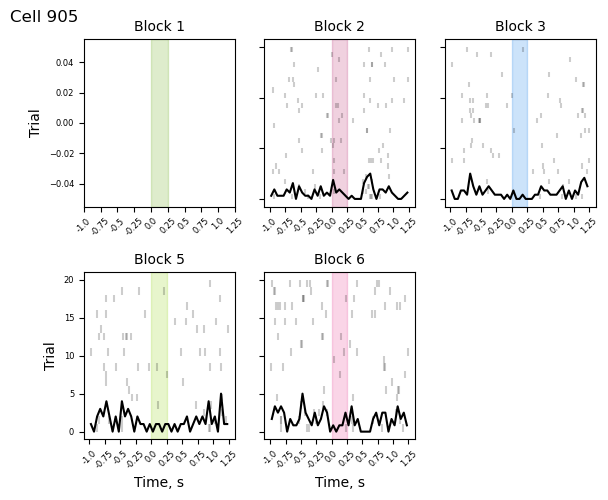

In [56]:
for unit in neuron_ids:
    best_cell_trial_activity(unit, active_blocks)

## Significant activation

In [179]:
def find_spikes_in_interesting_behavioral_window(beforesamples, aftersamples, blocks, units=goodspiketimes.keys()):
    ''' 
    beforesamples, aftersamples relative to nosepoke window TestSocialSampleWindowPerTrial; expressed in samples: 0.250 ms = 5000 (20kHz sampling rate)
    blocks=[1,2,4,5]
    '''
    spikes_dic = {}
   
    for block in blocks:
        unitspikes = {}

        for unit in units: # list of good cluster_id
            unitspikes[unit] = {}
            
            for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1]
                
                cond1 = np.where(goodspiketimes[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes[unit][event] = goodspiketimes[unit][np.intersect1d(cond1,cond2)].astype(int)-onset
                
        spikes_dic[block] = unitspikes
    
    return spikes_dic
        

In [180]:
# 250 ms during the nosepoke
spikes_dic_during = find_spikes_in_interesting_behavioral_window(beforesamples=0, aftersamples=0, blocks=active_blocks)

#### Poisson test

In [324]:
# find mean firing rate across a whole block

StartTrial = load_behavioral_event(1)
EndTrial = load_behavioral_event(2)

mean_fr_across_block = {}
psth_whole_block = {}

for block in active_blocks:

    block_start = StartTrial[block][0]
    block_end = EndTrial[block][-1]
    block_duration = block_end-block_start

    # binned_firing_rate
    binsize = 1000 ### 50 ms 
    binz = np.linspace(block_start, block_end, int((block_end-block_start)/binsize)+1)

    unit_meanfr = {}
    eventhistz = {}
    
    for unit in neuron_ids:
        cnt=0
        for spike in goodspiketimes[unit]:
            if spike>=block_start and spike<=block_end:
                cnt+=1
        mean_fr = (cnt/block_duration)*20000 # spikes/sec
        unit_meanfr[unit] = mean_fr

        eventhistz[unit] = np.histogram(goodspiketimes[unit], bins=binz)[0]/(binsize/20000) # spikes/sec
            

    psth_whole_block[block] = eventhistz

    mean_fr_across_block[block] = unit_meanfr

In [313]:
psth_whole_block[1][687][:20]

array([  0.,   0.,   0.,  20.,   0.,  20.,  20.,   0.,  60.,  60.,   0.,
        20.,  40.,  60.,  60.,  40.,  40.,  20., 160.,  60.])

In [314]:
mean_fr_across_block[1][687]

61.34002075928982

In [185]:
from scipy.stats import poisson

In [345]:
poisson_outcomes = {}
alpha = 0.01

for block in active_blocks:
    unit_outcomes = {}
    for unit in neuron_ids:
        stat_outcomes = []
        l = mean_fr_across_block[block][unit]
        for fr in psth_whole_block[block][unit]:
            p_value = poisson.sf(fr, l) if fr > l else poisson.cdf(fr, l)
            if p_value <= alpha:
                if fr>l:
                    stat_outcomes.append(2)
                else:
                    stat_outcomes.append(1)
            else:
                stat_outcomes.append(0)
        unit_outcomes[unit] = stat_outcomes
    poisson_outcomes[block] = unit_outcomes

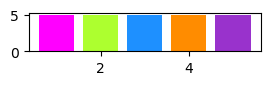

In [58]:
palettee = ['#FF00FF','#ADFF2F', '#1E90FF', '#FF8C00', '#9932CC']

x = [1, 2, 3, 4, 5]
y = [5,5,5,5,5]

plt.figure(figsize=(3, 0.5))
for i in range(5):
    plt.bar(x[i], y[i], color = palettee[i]) 

plt.show()

In [352]:
poisson_outcomes[1][615][:5]

[1, 1, 1, 2, 0]

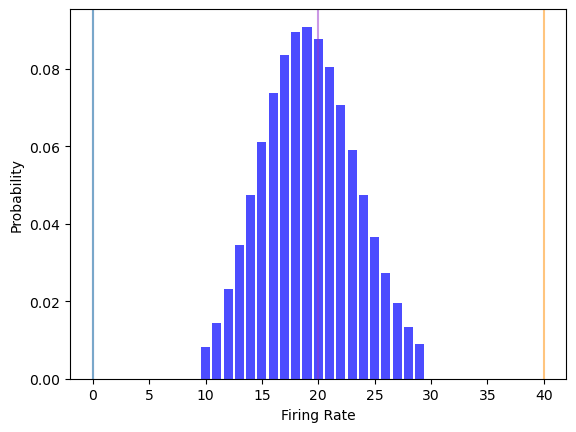

In [354]:
# Example data: firing rates
firing_rates = psth_whole_block[1][615]

# Calculate the mean firing rate
lambda_ = np.mean(firing_rates)

# Generate Poisson distribution for a reasonable range around the observed rates
x = np.arange(poisson.ppf(0.01, lambda_), poisson.ppf(0.99, lambda_))
pmf = poisson.pmf(x, lambda_)

# Plotting the Poisson distribution
plt.bar(x, pmf, label='Poisson PMF', alpha=0.7, color='blue')

# Overlay the observed firing rates as vertical lines
colors = ['#FF00FF','#ADFF2F', '#1E90FF', '#FF8C00', '#9932CC']
for i, rate in enumerate(firing_rates[:5]):
    plt.axvline(x=rate, color = colors[i], alpha=0.5, linewidth=1.5)


plt.xlabel('Firing Rate')
plt.ylabel('Probability')


# Show the plot
plt.show()

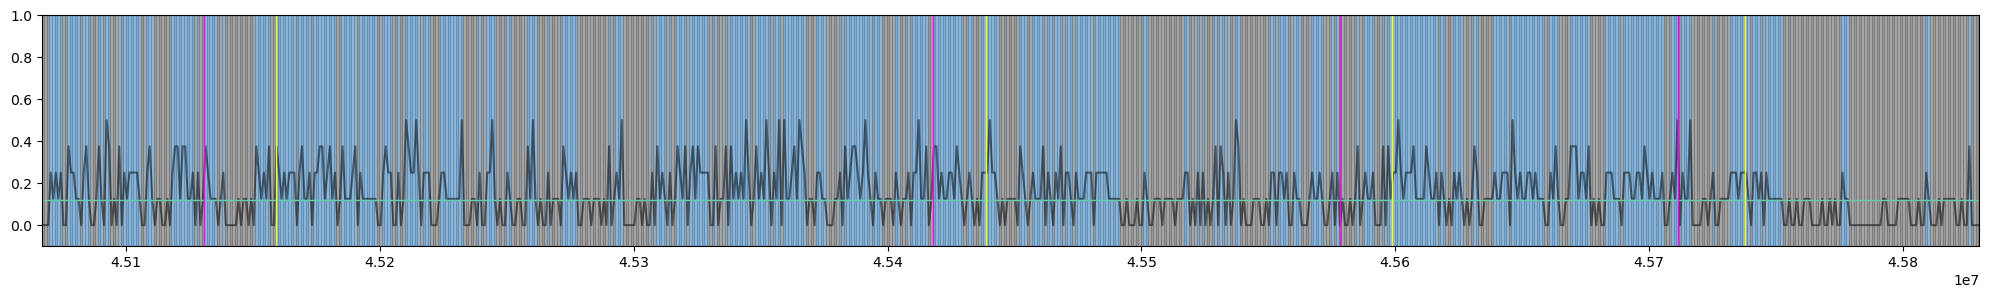

In [358]:
unit = 615
for block in [1]: #active_blocks:

    block_start = StartTrial[block][0]
    block_end = EndTrial[block][-1]
    block_duration = block_end-block_start
    binsize = 1000 ### 50 ms 
    binz = np.linspace(block_start, block_end, int((block_end-block_start)/binsize)+1)

    plt.figure(figsize=(25,3))
    # psth
    psth_minmax = (psth_whole_block[block][unit] - np.min(psth_whole_block[block][unit])) / (np.max(psth_whole_block[block][unit]) - np.min(psth_whole_block[block][unit]))
    plt.plot((binz[1:]+binz[:-1])/2, psth_minmax, color='black', alpha=0.5)

    # significant activation/inhibition poisson
    for i, bit in enumerate(poisson_outcomes[block][unit]):
        if bit == 1:
            color = '#696969' # grey - inhibition
        elif bit==2:
            color = '#4682B4' #blue - activation
        elif bit==0:
            color == 'white'
        plt.axvspan(i*binsize+block_start, (i+1)*binsize+block_start, color=color, alpha=0.5)
    plt.axhline(np.mean(psth_minmax), color='#66CDAA', linewidth = 1)

    # npoke events
    for npoke in range(len(TestSocialSampleWindowPerTrial[block])):
        plt.axvline(TestSocialSampleWindowPerTrial[block][npoke,0], color = '#FF00FF', linewidth = 1) # pink

    # decision
    choice_arr = EvaBehavior['Behaviour'][block][18]*20000
    for choice in range(len(TestSocialSampleWindowPerTrial[block])):
        plt.axvline(choice_arr[choice], color = '#FFFF00', linewidth = 1) #yellow
    
    # ZOOOOOM
    plt.gca().set(xlim=(block_start, int(block_start+block_duration/30)), ylim=(-0.1, 1))

    plt.plot()


## Distance bw vectors

* bw each two in a block (for 1 mouse and for different mice)
* bw blocks
* bw sessions

### Firing rates

firing rate [Hz] = spike_count/ time_window(sec)

* lets find it for each trial for each cell
* we will make an array where each row is trial; each column - neuron; we will collect it in dict where keys = blocks

In [70]:
window = 0.25 #sec
firing_rates_dic = {}

for block in active_blocks:
    firing_rates_2d = []
    for unit in spikes_dic_during[block].keys():
        firing_rates_list = []
        for event in spikes_dic_during[block][unit].keys():
            firing_rate = len(spikes_dic_during[block][unit][event])/window
            firing_rates_list.append(firing_rate)
        firing_rates_vector = np.array(firing_rates_list)
        firing_rates_2d.append(firing_rates_vector)
    firing_rates_matrix = np.array(firing_rates_2d).T
    firing_rates_dic[block] = firing_rates_matrix

In [71]:
firing_rates_dic[2].shape # raws - trials; col - neurons

(30, 13)

### Euclidean distance

#### alpha1 block vs beta1 block trial by trial

In [72]:
def eucidean_dist_bw_blocks(block_x,block_y):
    '''
    compares a vs b neuronal vectors trial by trial
    block_x = firingrate_neuron_event_1
    block_y = firingrate_neuron_event_2
    '''
    distances = []
    for row in range(block_x.shape[0]):
        A = block_x[row, :]
        B = block_y[row, :]
        # Calculate the Euclidean distance
        dist = np.linalg.norm(A-B)
        distances.append(dist)
    return distances

In [73]:
# control: shuffle trials
a1 = firing_rates_dic[1]
b1 = firing_rates_dic[2]

a1b1 = np.concatenate((a1,b1), axis=0)
idx = np.arange(len(a1b1))
np.random.shuffle(idx)
a1b1_sh = a1b1[idx]
a1_sh = a1b1_sh[:len(a1)]
b1_sh = a1b1_sh[len(a1):]

In [74]:
# alpha1 vs beta1
dist_a1b1 = eucidean_dist_bw_blocks(a1,b1)
dist_a1b1_sh = eucidean_dist_bw_blocks(a1_sh,b1_sh)

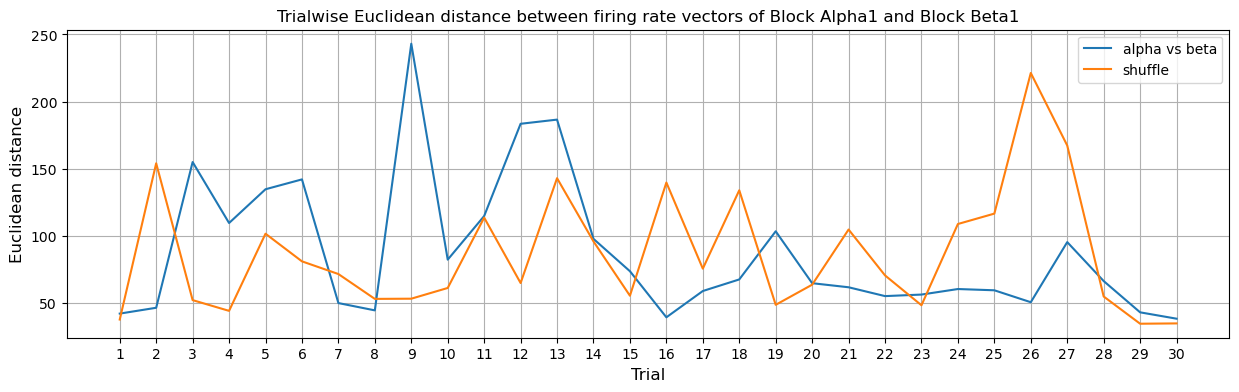

In [75]:
plt.figure(figsize=(15,4)) 
plt.plot(dist_a1b1, label='alpha vs beta')
plt.plot(dist_a1b1_sh, label='shuffle')
plt.xlabel('Trial',  fontsize=12)
plt.ylabel('Euclidean distance',  fontsize=12)
plt.title("Trialwise Euclidean distance between firing rate vectors of Block Alpha1 and Block Beta1")
plt.xticks(np.arange(len(dist_a1b1)), labels=np.arange(len(dist_a1b1))+1, fontsize=10)
plt.grid(True)
plt.legend()

plt.show()

#### 1st trial of alpha1 block vs all subsequent trials of alpha1 block

In [76]:
def eucidean_dist_bw_vectors(block):
    v1 = block[0,:]
    remaining_block = block[1:,:]
    distances = []
    for v in range(len(remaining_block)):
        distances.append(np.linalg.norm(v1-remaining_block[v,:]))
    return distances

In [77]:
# control
a1 = firing_rates_dic[1]
idx = np.arange(len(a1))
np.random.shuffle(idx)
a1_sh = a1[idx]

In [78]:
dist_a1 = eucidean_dist_bw_vectors(a1)
dist_a1_sh = eucidean_dist_bw_vectors(a1_sh)

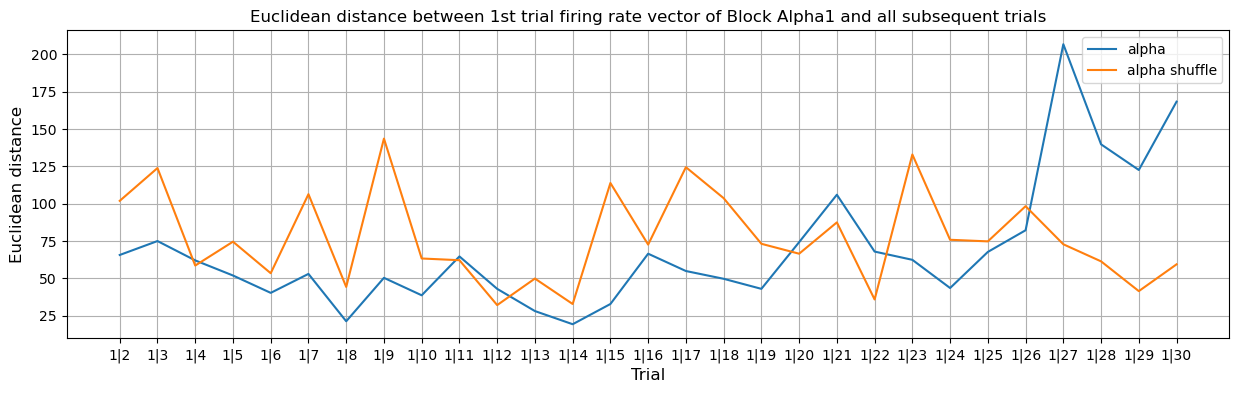

In [79]:
plt.figure(figsize=(15,4)) 
plt.plot(dist_a1, label='alpha')
plt.plot(dist_a1_sh, label='alpha shuffle')
plt.xlabel('Trial',  fontsize=12)
plt.ylabel('Euclidean distance',  fontsize=12)
plt.title("Euclidean distance between 1st trial firing rate vector of Block Alpha1 and all subsequent trials")
plt.xticks(np.arange(len(dist_a1)), labels=[f'1|{i}' for i in range(2, len(a1) + 1)], fontsize=10)
plt.grid(True)
plt.legend()

plt.show()

#### 1st trial of beta1 block vs all subsequent trials of beta1 block

In [80]:
# control
b1 = firing_rates_dic[2]
idx = np.arange(len(b1))
np.random.shuffle(idx)
b1_sh = b1[idx]

In [81]:
dist_b1 = eucidean_dist_bw_vectors(b1)
dist_b1_sh = eucidean_dist_bw_vectors(b1_sh)

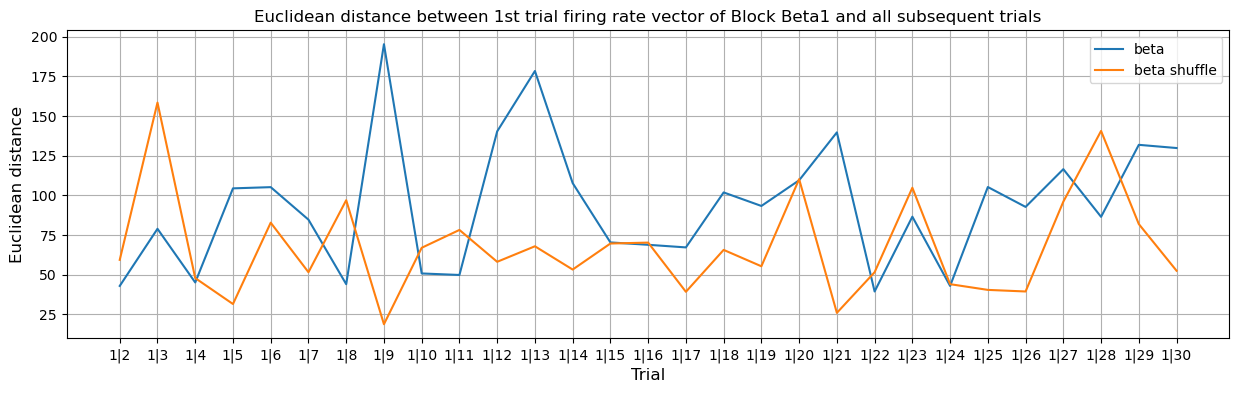

In [82]:
plt.figure(figsize=(15,4)) 
plt.plot(dist_b1, label='beta')
plt.plot(dist_b1_sh, label='beta shuffle')
plt.xlabel('Trial',  fontsize=12)
plt.ylabel('Euclidean distance',  fontsize=12)
plt.title("Euclidean distance between 1st trial firing rate vector of Block Beta1 and all subsequent trials")
plt.xticks(np.arange(len(dist_b1)), labels=[f'1|{i}' for i in range(2, len(b1) + 1)], fontsize=10)
plt.grid(True)
plt.legend()

plt.show()

## Mahalanobis distance between two clusters
1) compute the covariance matrix and the mean vectors for each cluster
2) compute the Mahalanobis distance

In [83]:
from scipy.spatial.distance import mahalanobis

In [84]:
sorted_neurons

[(687, 99.63636363636364),
 (615, 34.54545454545455),
 (690, 29.727272727272727),
 (617, 15.454545454545455),
 (627, 8.909090909090908),
 (695, 6.818181818181818),
 (651, 4.363636363636363),
 (344, 3.090909090909091),
 (667, 1.0909090909090908),
 (679, 0.5454545454545454),
 (645, 0.45454545454545453),
 (683, 0.09090909090909091),
 (49, 0.0)]

In [85]:
sorted_neurons_filtered = [(neuron_id, firing_rate) for neuron_id, firing_rate in sorted_neurons if firing_rate >= 1]
sorted_neurons_filtered

[(687, 99.63636363636364),
 (615, 34.54545454545455),
 (690, 29.727272727272727),
 (617, 15.454545454545455),
 (627, 8.909090909090908),
 (695, 6.818181818181818),
 (651, 4.363636363636363),
 (344, 3.090909090909091),
 (667, 1.0909090909090908)]

In [86]:
filtered_neurons_ids = [neuron_id for neuron_id, firing_rate in sorted_neurons if firing_rate >= 1]
filtered_neurons_ids

[687, 615, 690, 617, 627, 695, 651, 344, 667]

In [87]:
window = 0.25 #sec
firing_rates_dic_filtered = {}

for block in active_blocks:
    firing_rates_2d = []
    for unit in filtered_neurons_ids:
        firing_rates_list = []
        for event in spikes_dic_during[block][unit].keys():
            firing_rate = len(spikes_dic_during[block][unit][event])/window
            firing_rates_list.append(firing_rate)
        firing_rates_vector = np.array(firing_rates_list)
        firing_rates_2d.append(firing_rates_vector)
    firing_rates_matrix = np.array(firing_rates_2d).T
    firing_rates_dic_filtered[block] = firing_rates_matrix

In [88]:
spikes_dic_during[1].keys()

dict_keys([49, 344, 615, 617, 627, 645, 651, 667, 679, 683, 687, 690, 695])

In [89]:
firing_rates_dic_filtered[1].shape  # raws - trials; col - neurons

(30, 9)

In [90]:
firing_rates_concat = np.concatenate([firing_rates_dic_filtered[1], firing_rates_dic_filtered[2]],axis=0)
firing_rates_concat.shape

(60, 9)

In [91]:
covar = np.cov(firing_rates_concat.T)
covar.shape

(9, 9)

In [92]:
covarinv = np.linalg.inv(covar)
covarinv.shape

(9, 9)

In [93]:
# Assuming cluster_points is a 2D NumPy array where each row represents a point in the cluster
centroid_a = np.mean(firing_rates_dic_filtered[1], axis=0)
centroid_b = np.mean(firing_rates_dic_filtered[2], axis=0)

In [94]:
MDic_a = [mahalanobis(x, centroid_a, covarinv) for x in firing_rates_dic_filtered[1]]
MDoc_a = [mahalanobis(x, centroid_a, covarinv) for x in firing_rates_dic_filtered[2]]

MDic_b = [mahalanobis(x, centroid_b, covarinv) for x in firing_rates_dic_filtered[2]]
MDoc_b = [mahalanobis(x, centroid_b, covarinv) for x in firing_rates_dic_filtered[1]]

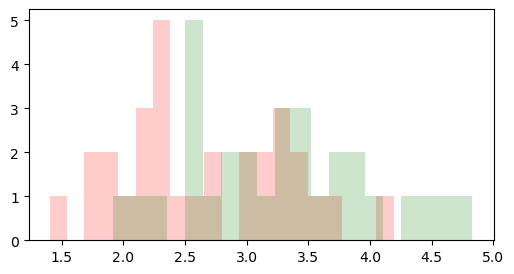

In [95]:
plt.figure(figsize=(6,3)) 
plt.hist(MDic_a, alpha=0.2, bins=20, color='red')
plt.hist(MDoc_a, alpha=0.2, bins=20, color='green')
plt.show()

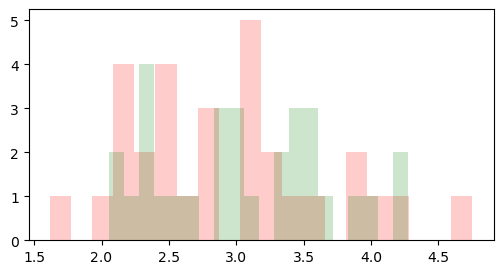

In [96]:
plt.figure(figsize=(6,3)) 
plt.hist(MDic_b, alpha=0.2, bins=20, color='red')
plt.hist(MDoc_b, alpha=0.2, bins=20, color='green')
plt.show()

In [97]:
def separability_metric(MDic_a,MDic_b,MDoc_a,MDoc_b):
    return (np.sum(MDic_a)+np.sum(MDic_b)) - (np.sum(MDoc_a)+np.sum(MDoc_b))

In [98]:
metric = separability_metric(MDic_a,MDic_b,MDoc_a,MDoc_b)

In [99]:
# control
# firing_rates_concat
trial_nb = len(firing_rates_dic_filtered[1])
idx = np.arange(len(firing_rates_concat))
np.random.shuffle(idx)
firing_rates_concat_sh = firing_rates_concat[idx]
firing_rates_a_sh = firing_rates_concat_sh[:trial_nb,:]
firing_rates_b_sh = firing_rates_concat_sh[trial_nb:,:]
firing_rates_a_sh.shape, firing_rates_b_sh.shape

((30, 9), (30, 9))

In [100]:
trial_nb = len(firing_rates_dic_filtered[1])

idx = np.arange(len(firing_rates_concat))
metrics_ctrl_list = []

for shuffle in range(1000):
    np.random.shuffle(idx)
    firing_rates_concat_sh = firing_rates_concat[idx]
    firing_rates_a_sh = firing_rates_concat_sh[:trial_nb,:]
    firing_rates_b_sh = firing_rates_concat_sh[trial_nb:,:]

    centroid_a_ctrl = np.mean(firing_rates_a_sh, axis=0)
    centroid_b_ctrl = np.mean(firing_rates_b_sh, axis=0)

    MDic_a_ctrl = [mahalanobis(x, centroid_a_ctrl, covarinv) for x in firing_rates_a_sh]
    MDoc_a_ctrl = [mahalanobis(x, centroid_a_ctrl, covarinv) for x in firing_rates_b_sh]

    MDic_b_ctrl = [mahalanobis(x, centroid_b_ctrl, covarinv) for x in firing_rates_b_sh]
    MDoc_b_ctrl = [mahalanobis(x, centroid_b_ctrl, covarinv) for x in firing_rates_a_sh]

    metrics_ctrl_list.append(separability_metric(MDic_a_ctrl,MDic_b_ctrl,MDoc_a_ctrl,MDoc_b_ctrl))


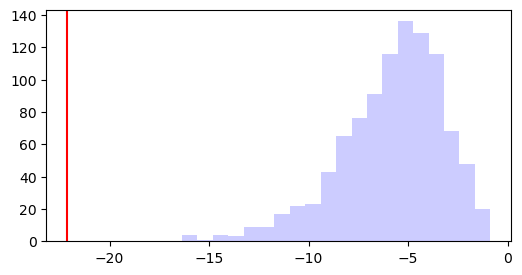

In [101]:
plt.figure(figsize=(6,3)) 
plt.hist(metrics_ctrl_list, alpha=0.2, bins=20, color='blue')
plt.axvline(metric,color='red')
plt.show()

In [103]:
from scipy import stats

In [104]:
# Perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(metrics_ctrl_list, metric)

# Define significance level
alpha = 0.01

# Compare p-value with significance level
if p_value < alpha:
    print("Reject null hypothesis: Single number is statistically different from population.")
else:
    print("Fail to reject null hypothesis: Single number is not statistically different from population.")

Reject null hypothesis: Single number is statistically different from population.


##### Lets try other windows then a nosepoke

In [105]:
# before = onset - 1000 ms : offset - 500 ms
spikes_dic_bef = find_spikes_in_interesting_behavioral_window(beforesamples=20000, aftersamples=-10000, blocks=active_blocks)

In [106]:
# after = offset+500ms : offset+1000ms
spikes_dic_af = find_spikes_in_interesting_behavioral_window(beforesamples=-10000, aftersamples=20000, blocks=active_blocks)

In [107]:
def data_for_MD(window_dic, window):

    # window_dic = spikes_dic_bef
    # window = 0.5 #sec
    
    # data prep
    firing_rates_dic_filtered = {}
    
    for block in active_blocks:
        firing_rates_2d = []
        for unit in filtered_neurons_ids:
            firing_rates_list = []
            for event in window_dic[block][unit].keys():
                firing_rate = len(spikes_dic_during[block][unit][event])/window
                firing_rates_list.append(firing_rate)
            firing_rates_vector = np.array(firing_rates_list)
            firing_rates_2d.append(firing_rates_vector)
        firing_rates_matrix = np.array(firing_rates_2d).T
        firing_rates_dic_filtered[block] = firing_rates_matrix

    # MD prep
    fr_concat = np.concatenate([firing_rates_dic_filtered[1], firing_rates_dic_filtered[2]],axis=0)
    covar = np.cov(fr_concat.T)
    covarinv = np.linalg.inv(covar)

    # centroids
    centroid_a = np.mean(firing_rates_dic_filtered[1], axis=0)
    centroid_b = np.mean(firing_rates_dic_filtered[2], axis=0)

    # inter- and outer- cluster ditances
    MDic_a = [mahalanobis(x, centroid_a, covarinv) for x in firing_rates_dic_filtered[1]]
    MDoc_a = [mahalanobis(x, centroid_a, covarinv) for x in firing_rates_dic_filtered[2]]

    MDic_b = [mahalanobis(x, centroid_b, covarinv) for x in firing_rates_dic_filtered[2]]
    MDoc_b = [mahalanobis(x, centroid_b, covarinv) for x in firing_rates_dic_filtered[1]]
    
    metric = separability_metric(MDic_a,MDic_b,MDoc_a,MDoc_b)

    #CONTROL
    trial_nb = len(firing_rates_dic_filtered[1])

    idx = np.arange(len(firing_rates_concat))
    metrics_ctrl_list = []

    for shuffle in range(1000):
        np.random.shuffle(idx)
        firing_rates_concat_sh = firing_rates_concat[idx]
        firing_rates_a_sh = firing_rates_concat_sh[:trial_nb,:]
        firing_rates_b_sh = firing_rates_concat_sh[trial_nb:,:]

        centroid_a_ctrl = np.mean(firing_rates_a_sh, axis=0)
        centroid_b_ctrl = np.mean(firing_rates_b_sh, axis=0)

        MDic_a_ctrl = [mahalanobis(x, centroid_a_ctrl, covarinv) for x in firing_rates_a_sh]
        MDoc_a_ctrl = [mahalanobis(x, centroid_a_ctrl, covarinv) for x in firing_rates_b_sh]

        MDic_b_ctrl = [mahalanobis(x, centroid_b_ctrl, covarinv) for x in firing_rates_b_sh]
        MDoc_b_ctrl = [mahalanobis(x, centroid_b_ctrl, covarinv) for x in firing_rates_a_sh]

        metrics_ctrl_list.append(separability_metric(MDic_a_ctrl,MDic_b_ctrl,MDoc_a_ctrl,MDoc_b_ctrl))




    return metric, metrics_ctrl_list

In [108]:
metric_bf, metrics_ctrl_list_bf = data_for_MD(spikes_dic_bef, 0.5)
metric_af, metrics_ctrl_list_af = data_for_MD(spikes_dic_af, 0.5)

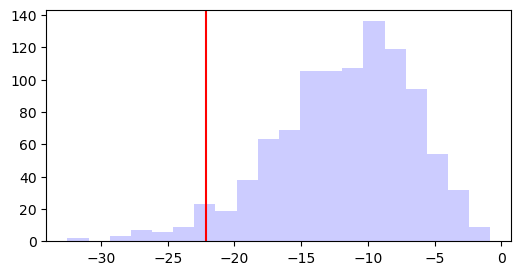

In [109]:
plt.figure(figsize=(6,3)) 
plt.hist(metrics_ctrl_list_bf, alpha=0.2, bins=20, color='blue')
plt.axvline(metric_bf,color='red')
plt.show()

In [110]:
# Perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(metrics_ctrl_list_bf, metric_bf)

# Define significance level
alpha = 0.001

# Compare p-value with significance level
if p_value < alpha:
    print("Reject null hypothesis: Single number is statistically different from population.")
else:
    print("Fail to reject null hypothesis: Single number is not statistically different from population.")

Reject null hypothesis: Single number is statistically different from population.


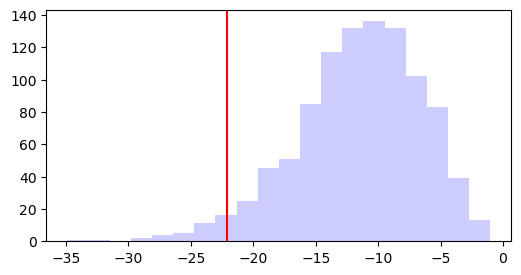

In [111]:
plt.figure(figsize=(6,3)) 
plt.hist(metrics_ctrl_list_af, alpha=0.2, bins=20, color='blue')
plt.axvline(metric_af,color='red')
plt.show()

In [112]:
# Perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(metrics_ctrl_list_af, metric_af)

# Define significance level
alpha = 0.001

# Compare p-value with significance level
if p_value < alpha:
    print("Reject null hypothesis: Single number is statistically different from population.")
else:
    print("Fail to reject null hypothesis: Single number is not statistically different from population.")

Reject null hypothesis: Single number is statistically different from population.


In [115]:
sample_data = metrics_ctrl_list

# Specified value to compare against
specified_value = metric

# Perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(sample_data, specified_value)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Compare the p-value to a significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference.")

T-statistic: 196.0276008694914
P-value: 0.0
Reject the null hypothesis. There is a significant difference.


## PCA

In [123]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        #ax.add_patch(Ellipse(position, nsig * width, nsig * height, **kwargs))
        ax.add_patch(Ellipse(position, nsig*width, nsig*height, angle=angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

def plot_gmm_ellipse(gmm, X, label=True, ax=None):
    # ax = ax or plt.gca()
    # labels = gmm.fit(X).predict(X)
    # if label:
    #     ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    # else:
    #     ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    # ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [117]:
pca = PCA(n_components=2)  # You can choose the number of components you want
X_pca = pca.fit_transform(firing_rates_concat)

In [118]:
X_pca.shape

(60, 2)

In [119]:
gmm = GaussianMixture(n_components=2)  # You can choose the number of clusters
gmm.fit(X_pca)

c:\Users\ebukina\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


GaussianMixture(n_components=2)

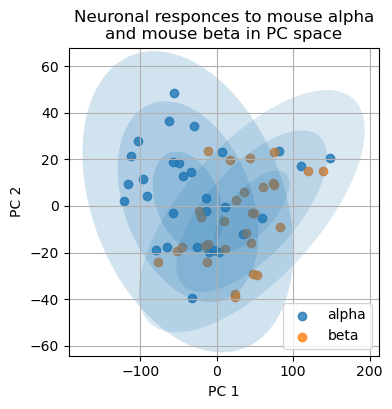

In [124]:
plt.figure(figsize=(4, 4))
plt.scatter(X_pca[:30, 0], X_pca[:30, 1], alpha=0.8, label='alpha')
plt.scatter(X_pca[30:, 0], X_pca[30:, 1], alpha=0.8, label='beta')
plot_gmm_ellipse(gmm, X_pca)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Neuronal responces to mouse alpha\nand mouse beta in PC space')
plt.legend()
plt.grid(True)

## Classifiers

In [545]:
classifiers_results = {}

In [126]:
motor_planning_control = False

In [125]:
choice_1 = EvaBehavior['Behaviour'][1][19]
choice_2 = EvaBehavior['Behaviour'][2][19]
choice_3 = EvaBehavior['Behaviour'][4][19]
choice_4 = EvaBehavior['Behaviour'][5][19]

### Train blocks12; test blocks 34

#### SVM

In [127]:
# Importing necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [129]:
X_train = np.concatenate((firing_rates_dic[1],firing_rates_dic[2]), axis=0)
X_test = np.concatenate((firing_rates_dic[4],firing_rates_dic[5]), axis=0)

if motor_planning_control:
    y_train = np.concatenate((choice_1,choice_2))
    y_test = np.concatenate((choice_3,choice_4))
else:
    y_train = np.concatenate((np.ones(30),np.zeros(30)))
    y_test = np.concatenate((np.ones(20),np.zeros(20)))

# randomize train
num_rows = X_train.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [552]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((60, 24), (60,), (40, 24), (40,))

In [130]:
kernel = 'linear'

svm_classifier = SVC(kernel=kernel)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6


In [131]:
svm_mean_scores_ctrl = []

for shuffle in range(1000):
    # shuffle trials in the matrix
    num_rows = X_test.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl = X_test[shuffled_indices]

    # shuffle outcomes
    num_rows = X_test.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    yctrl = y_test[shuffled_indices]

    svm_mean_scores_ctrl.append(accuracy_score(yctrl, svm_classifier.predict(Xctrl)))

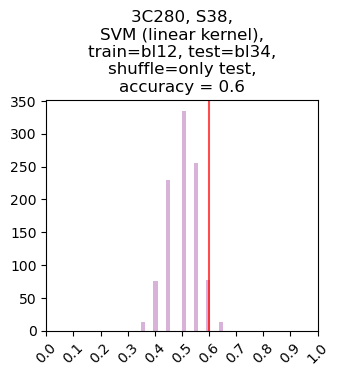

In [132]:
plt.figure(figsize=(3.5,3)) 
plt.hist(svm_mean_scores_ctrl, bins=20, alpha=0.3, color='purple')
plt.axvline(accuracy,color='red', alpha=0.7)
plt.title(f'3C280, S38,\nSVM ({kernel} kernel),\ntrain=bl12, test=bl34,\nshuffle=only test,\naccuracy = {accuracy}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

In [ ]:
svm_ctrl = []

for shuffle in range(1000):
    ## shuffle train
    num_rows = X_train.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl_train = X_train[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl_train = y_train[shuffled_indices]

    ## shuffle test
    # shuffle trials in the matrix
    num_rows = X_test.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl = X_test[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl = y_test[shuffled_indices]

    svm_classifier_ctrl = SVC(kernel=kernel)
    svm_classifier_ctrl.fit(Xctrl_train, yctrl_train)
    svm_ctrl.append(accuracy_score(yctrl, svm_classifier_ctrl.predict(Xctrl)))

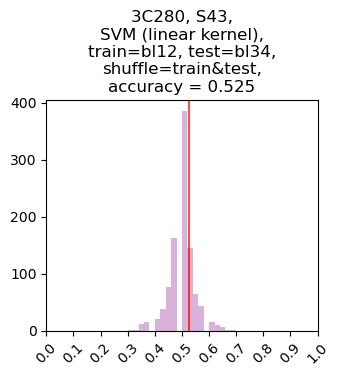

In [ ]:
plt.figure(figsize=(3.5,3)) 
plt.hist(svm_ctrl, bins=20, alpha=0.3, color='purple')
plt.axvline(accuracy,color='red', alpha=0.7)
plt.title(f'3C280, S43,\nSVM ({kernel} kernel),\ntrain=bl12, test=bl34,\nshuffle=train&test,\naccuracy = {accuracy}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

##### Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_bayes = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy_bayes)

Accuracy: 0.475


In [ ]:
accuracy_bayes_ctrl = []

for shuffle in range(1000):
    
    num_rows = X_test.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl = X_test[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl = y_test[shuffled_indices]

    accuracy_bayes_ctrl.append(accuracy_score(yctrl, classifier.predict(Xctrl)))

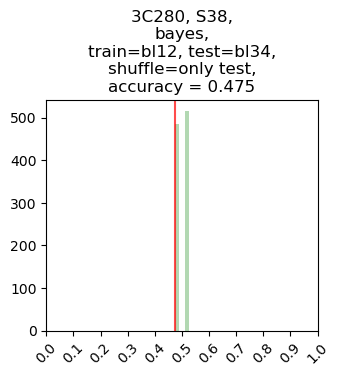

In [ ]:
plt.figure(figsize=(3.5,3)) 
plt.hist(accuracy_bayes_ctrl, bins=4, alpha=0.3, color='green')
plt.axvline(accuracy_bayes ,color='red', alpha=0.7)
plt.title(f'3C280, S38,\nbayes,\ntrain=bl12, test=bl34,\nshuffle=only test,\naccuracy = {accuracy_bayes}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

In [ ]:
bayes_ctrl = []

for shuffle in range(1000):
    ## shuffle train
    num_rows = X_train.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl_train = X_train[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl_train = y_train[shuffled_indices]

    ## shuffle test
    # shuffle trials in the matrix
    num_rows = X_test.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    Xctrl = X_test[shuffled_indices]
    random.shuffle(shuffled_indices)
    yctrl = y_test[shuffled_indices]

    classifier_ctrl = GaussianNB()
    classifier_ctrl.fit(Xctrl_train, yctrl_train)
    bayes_ctrl.append(accuracy_score(yctrl, classifier_ctrl.predict(Xctrl)))

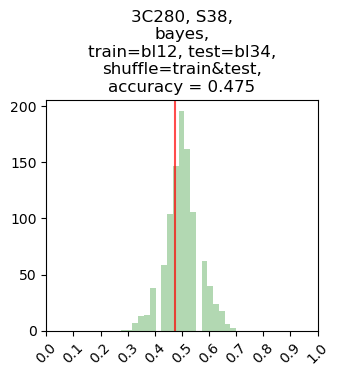

In [ ]:
plt.figure(figsize=(3.5,3)) 
plt.hist(bayes_ctrl, bins=20, alpha=0.3, color='green')
plt.axvline(accuracy_bayes ,color='red', alpha=0.7)
plt.title(f'3C280, S38,\nbayes,\ntrain=bl12, test=bl34,\nshuffle=train&test,\naccuracy = {accuracy_bayes}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

### Cross-validation on all dataset

#### SVM

In [557]:
# data prep
alpha_data = np.concatenate((firing_rates_dic[1],firing_rates_dic[5]), axis=0)
beta_data = np.concatenate((firing_rates_dic[2],firing_rates_dic[6]), axis=0)

if motor_planning_control:
    y_13 = np.concatenate((choice_1, choice_3))
    y_24 = np.concatenate((choice_2, choice_4))

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
y_13 = y_13[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]
y_24 = y_24[shuffled_indices]

IndexError: index 43 is out of bounds for axis 0 with size 40

In [ ]:
alpha_data.shape, beta_data.shape

((40, 27), (40, 27))

In [ ]:
test_ab.shape

(10, 30)

In [ ]:
cv=5
kernel = 'linear'

num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

accuracy_cv5 = []
accuracy_cv5_ctrl = []

for n in range(cv):
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    svm_classifier_cv = SVC(kernel=kernel)
    svm_classifier_cv.fit(train_ab, y_train)
    y_pred = svm_classifier_cv.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # shuffle outcomes
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab = test_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_test = y_test[shuffled_indices]

        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5_ctrl.append(accuracy_score(y_test, y_pred))





In [ ]:
accuracy_cv5, np.mean(accuracy_cv5)

([0.75, 0.8125, 0.5625, 0.375, 0.5625], 0.6125)

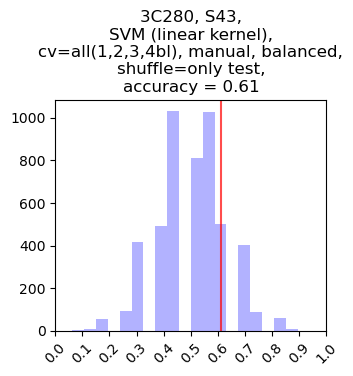

In [ ]:
plt.figure(figsize=(3.5,3)) 
plt.hist(accuracy_cv5_ctrl, bins=20, alpha=0.3, color='blue')
plt.axvline(np.mean(accuracy_cv5) ,color='red', alpha=0.7)
plt.title(f'3C280, S43,\nSVM ({kernel} kernel),\ncv=all(1,2,3,4bl), manual, balanced,\nshuffle=only test,\naccuracy = {np.mean(accuracy_cv5):.2f}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

In [ ]:
cv5_ctrl = []
for n in range(cv):
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

   
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_train = y_train[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab = test_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_test = y_test[shuffled_indices]

        svm_classifier = SVC(kernel=kernel)
        svm_classifier.fit(train_ab, y_train)
        y_pred = svm_classifier.predict(test_ab)
        cv5_ctrl.append(accuracy_score(y_test, y_pred))


KeyboardInterrupt: 

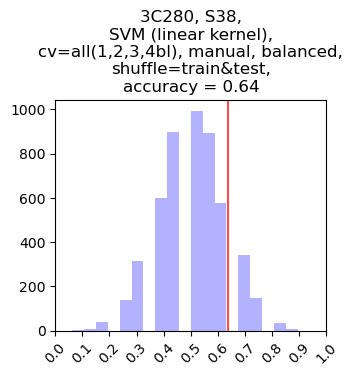

In [ ]:
plt.figure(figsize=(3.5,3)) 
plt.hist(cv5_ctrl, bins=20, alpha=0.3, color='blue')
plt.axvline(np.mean(accuracy_cv5) ,color='red', alpha=0.7)
plt.title(f'3C280, S38,\nSVM ({kernel} kernel),\ncv=all(1,2,3,4bl), manual, balanced,\nshuffle=train&test,\naccuracy = {np.mean(accuracy_cv5):.2f}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

#### Bayes

In [ ]:
# data prep
alpha_data = np.concatenate((firing_rates_dic[1],firing_rates_dic[4]), axis=0)
beta_data = np.concatenate((firing_rates_dic[2],firing_rates_dic[5]), axis=0)

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

In [ ]:
cv=5

num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

accuracy_cv5 = []
accuracy_cv5_ctrl = []

for n in range(cv):
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    classifier = GaussianNB()
    classifier.fit(train_ab, y_train)
    y_pred = classifier.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # shuffle outcomes
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab = test_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_test = y_test[shuffled_indices]

        y_pred = classifier.predict(test_ab)
        accuracy_cv5_ctrl.append(accuracy_score(y_test, y_pred))

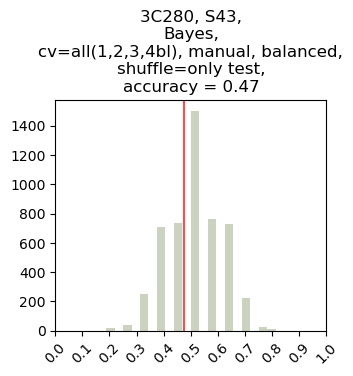

In [ ]:
plt.figure(figsize=(3.5,3)) 
plt.hist(accuracy_cv5_ctrl, bins=20, alpha=0.3, color='#556B2F')
plt.axvline(np.mean(accuracy_cv5) ,color='red', alpha=0.7)
plt.title(f'3C280, S43,\nBayes,\ncv=all(1,2,3,4bl), manual, balanced,\nshuffle=only test,\naccuracy = {np.mean(accuracy_cv5):.2f}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

In [ ]:
cv5_ctrl = []
for n in range(cv):
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

   
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_train = y_train[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab = test_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_test = y_test[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab, y_train)
        y_pred = classifier.predict(test_ab)
        cv5_ctrl.append(accuracy_score(y_test, y_pred))

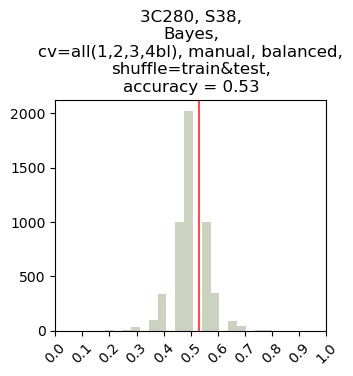

In [ ]:
plt.figure(figsize=(3.5,3)) 
plt.hist(cv5_ctrl, bins=20, alpha=0.3, color='#556B2F')
plt.axvline(np.mean(accuracy_cv5) ,color='red', alpha=0.7)
plt.title(f'3C280, S38,\nBayes,\ncv=all(1,2,3,4bl), manual, balanced,\nshuffle=train&test,\naccuracy = {np.mean(accuracy_cv5):.2f}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

### cross val on morning data

In [558]:
# data prep
alpha_data = firing_rates_dic[1]
beta_data = firing_rates_dic[2]

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

In [559]:
alpha_data.shape, beta_data.shape

((30, 24), (30, 24))

In [560]:
cv=5
kernel = 'rbf'

num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

accuracy_cv5 = []
accuracy_cv5_ctrl = []

for n in range(cv):
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    svm_classifier_cv = SVC(kernel=kernel)
    svm_classifier_cv.fit(train_ab, y_train)
    y_pred = svm_classifier_cv.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # shuffle outcomes
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab = test_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_test = y_test[shuffled_indices]

        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5_ctrl.append(accuracy_score(y_test, y_pred))

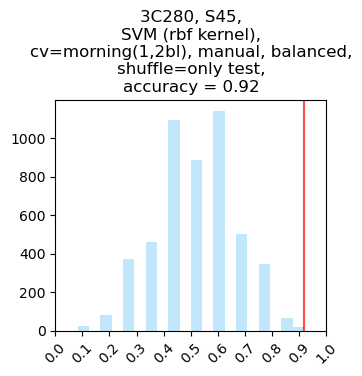

In [561]:
plt.figure(figsize=(3.5,3)) 
plt.hist(accuracy_cv5_ctrl, bins=20, alpha=0.5, color='#87CEFA')
plt.axvline(np.mean(accuracy_cv5) ,color='red', alpha=0.7)
plt.title(f'3C280, S45,\nSVM ({kernel} kernel),\ncv=morning(1,2bl), manual, balanced,\nshuffle=only test,\naccuracy = {np.mean(accuracy_cv5):.2f}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

In [ ]:
cv5_ctrl = []
for n in range(cv):
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

   
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_train = y_train[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab = test_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_test = y_test[shuffled_indices]

        svm_classifier = SVC(kernel=kernel)
        svm_classifier.fit(train_ab, y_train)
        y_pred = svm_classifier.predict(test_ab)
        cv5_ctrl.append(accuracy_score(y_test, y_pred))

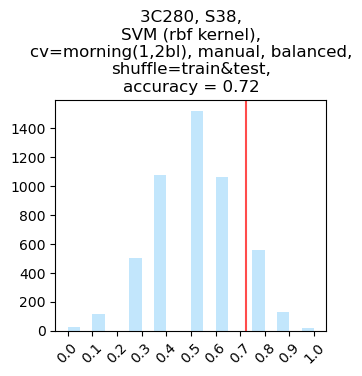

In [ ]:
plt.figure(figsize=(3.5,3)) 
plt.hist(cv5_ctrl, bins=20, alpha=0.5, color='#87CEFA')
plt.axvline(np.mean(accuracy_cv5) ,color='red', alpha=0.7)
plt.title(f'3C280, S38,\nSVM ({kernel} kernel),\ncv=morning(1,2bl), manual, balanced,\nshuffle=train&test,\naccuracy = {np.mean(accuracy_cv5):.2f}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

#### Bayes

In [ ]:
# data prep
alpha_data = firing_rates_dic[1]
beta_data = firing_rates_dic[2]

# randomize morning/evening
num_rows = alpha_data.shape[0]
shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)
alpha_data = alpha_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta_data = beta_data[shuffled_indices]

In [ ]:
cv=5


num_rows = alpha_data.shape[0]
indices = list(range(num_rows))
train_proportion = int(num_rows*0.2) #20 percent

accuracy_cv5 = []
accuracy_cv5_ctrl = []

for n in range(cv):
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    classifier = GaussianNB()
    classifier.fit(train_ab, y_train)
    y_pred = classifier.predict(test_ab)
    accuracy_cv5.append(accuracy_score(y_test, y_pred))

    # shuffle outcomes
    for shuffle in range(1000):
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab = test_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_test = y_test[shuffled_indices]

        y_pred = classifier.predict(test_ab)
        accuracy_cv5_ctrl.append(accuracy_score(y_test, y_pred))

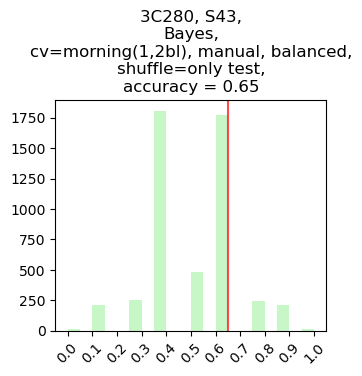

In [ ]:

plt.figure(figsize=(3.5,3)) 
plt.hist(accuracy_cv5_ctrl, bins=20, alpha=0.5, color='#90EE90')
plt.axvline(np.mean(accuracy_cv5) ,color='red', alpha=0.7)
plt.title(f'3C280, S43,\nBayes,\ncv=morning(1,2bl), manual, balanced,\nshuffle=only test,\naccuracy = {np.mean(accuracy_cv5):.2f}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

In [ ]:
cv5_ctrl = []
for n in range(cv):
    test_alpha_idx = random.sample(indices, train_proportion)
    train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
    test_alpha = alpha_data[test_alpha_idx]
    train_alpha = alpha_data[train_alpha_idx]

    test_beta_idx = random.sample(indices, train_proportion)
    train_beta_idx = [number for number in indices if number not in test_beta_idx]
    test_beta = beta_data[test_beta_idx]
    train_beta = beta_data[train_beta_idx]

    test_ab = np.concatenate((test_alpha,test_beta), axis=0)
    train_ab = np.concatenate((train_alpha,train_beta), axis=0)

    y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
    y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

   
    for shuffle in range(1000):
        # shuffle train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_train = y_train[shuffled_indices]

        # shuffle outcomes
        num_rows = test_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        test_ab = test_ab[shuffled_indices]
        random.shuffle(shuffled_indices)
        y_test = y_test[shuffled_indices]

        classifier = GaussianNB()
        classifier.fit(train_ab, y_train)
        y_pred = classifier.predict(test_ab)
        cv5_ctrl.append(accuracy_score(y_test, y_pred))

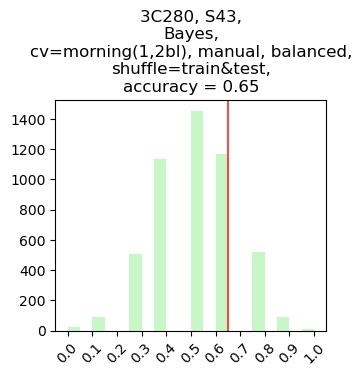

In [ ]:
plt.figure(figsize=(3.5,3)) 
plt.hist(cv5_ctrl, bins=20, alpha=0.5, color='#90EE90')
plt.axvline(np.mean(accuracy_cv5) ,color='red', alpha=0.7)
plt.title(f'3C280, S43,\nBayes,\ncv=morning(1,2bl), manual, balanced,\nshuffle=train&test,\naccuracy = {np.mean(accuracy_cv5):.2f}')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 1.1, 0.1)) 
plt.show()

### Cluster plot

In [ ]:
firingrate_means_1 = np.mean(firingrate_neuron_event_1, axis=1) # mean across events
firingrate_means_2 = np.mean(firingrate_neuron_event_2, axis=1)
firingrate_means_4 = np.mean(firingrate_neuron_event_4, axis=1)
firingrate_means_5 = np.mean(firingrate_neuron_event_5, axis=1)

NameError: name 'firingrate_neuron_event_1' is not defined

In [ ]:
firingrate_means_5.shape

(30,)

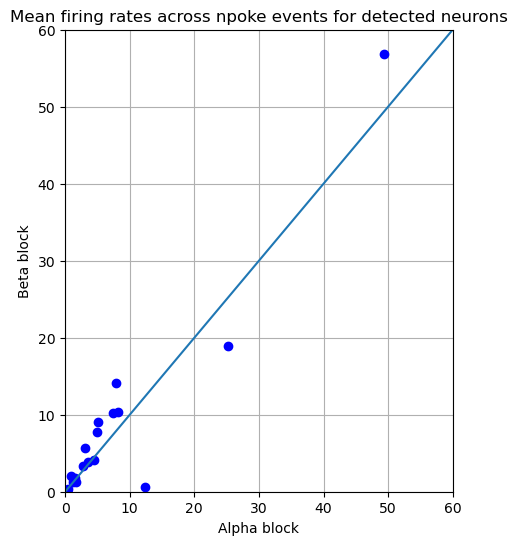

In [ ]:
plt.figure(figsize=(5,6))
plt.plot(firingrate_means_1, firingrate_means_2, 'bo')  # 'bo' specifies blue dots
plt.xlabel('Alpha block')
plt.ylabel('Beta block')
plt.title('Mean firing rates across npoke events for detected neurons')
plt.grid(True)
plt.ylim(0,60)
plt.xlim(0,60)
plt.plot([0,60],[0,60])
plt.show()

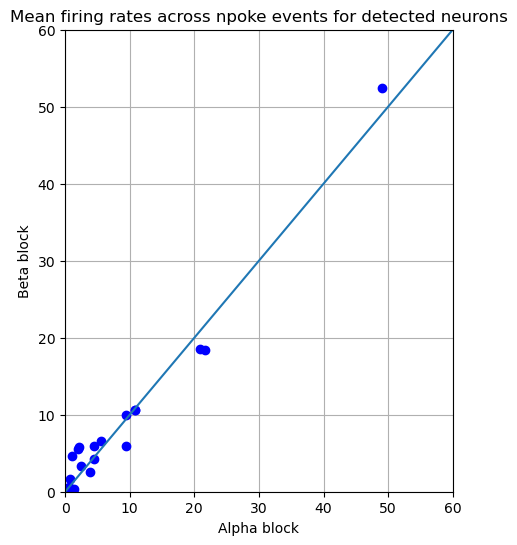

In [ ]:
plt.figure(figsize=(5,6))
plt.plot(firingrate_means_4, firingrate_means_5, 'bo')  # 'bo' specifies blue dots
plt.xlabel('Alpha block')
plt.ylabel('Beta block')
plt.title('Mean firing rates across npoke events for detected neurons')
plt.grid(True)
plt.ylim(0,60)
plt.xlim(0,60)
plt.plot([0,60],[0,60])
plt.show()

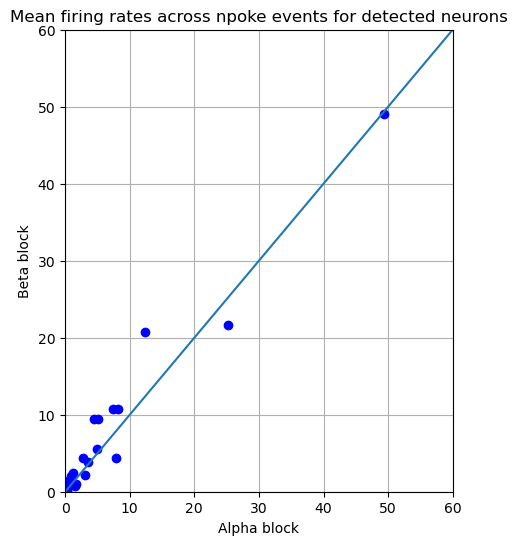

In [ ]:
plt.figure(figsize=(5,6))
plt.plot(firingrate_means_1, firingrate_means_4, 'bo')  # 'bo' specifies blue dots
plt.xlabel('Alpha block')
plt.ylabel('Beta block')
plt.title('Mean firing rates across npoke events for detected neurons')
plt.grid(True)
plt.ylim(0,60)
plt.xlim(0,60)
plt.plot([0,60],[0,60])
plt.show()

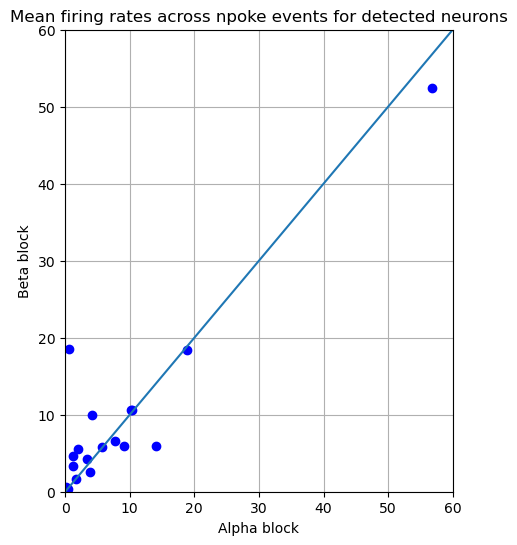

In [ ]:
plt.figure(figsize=(5,6))
plt.plot(firingrate_means_2, firingrate_means_5, 'bo')  # 'bo' specifies blue dots
plt.xlabel('Alpha block')
plt.ylabel('Beta block')
plt.title('Mean firing rates across npoke events for detected neurons')
plt.grid(True)
plt.ylim(0,60)
plt.xlim(0,60)
plt.plot([0,60],[0,60])
plt.show()

Normalised events

In [ ]:
#250 ms before
beforesamples = 5000 # 5000/20000=0.250 sec

block_event_unit_spikes_before = {} ## key1 - block_nb, key2 - event#, key3 - unite id

for block in [1,2,4,5]:
    
    # this one is 250ms before the event window
    eventspikes_cut = {} # key1 - event#, key2 - unite id

    for event in np.arange(SocialWindowTimes[block].shape[0]) : #iterate by npoke events

        eventspikes_cut[event] = {}

        onset = SocialWindowTimes[block][event,0]
        offset = SocialWindowTimes[block][event,1]
        
        for unit in goodspiketimes.keys() : #iterate by id of good neurons

            cond1 = np.where(goodspiketimes[unit].astype(int)>=onset-beforesamples)[0]
            cond2 = np.where(goodspiketimes[unit].astype(int)<=onset)[0]
            eventspikes_cut[event][unit] = goodspiketimes[unit][np.intersect1d(cond1,cond2)].astype(int)-onset
    block_event_unit_spikes_before[block] = eventspikes_cut

In [ ]:
def firing_rate_matrix_before(block,window=0.25): # window in sec to get Hz

    firingrate_neuron_event = [] #rows - neurons; cols - events (nb of window); inside - firing rate

    for event in block_event_unit_spikes_before[block].keys(): #nb of 250ms window
        firing_rate_vector = []

        for unit in block_event_unit_spikes_before[block][0].keys():
            
            firing_rate_vector.append(len(block_event_unit_spikes_before[block][event][unit])/window)
        firingrate_neuron_event.append(firing_rate_vector)

    return np.array(firingrate_neuron_event).T

In [ ]:
firingrate_neuron_event_1_bf = firing_rate_matrix_before(block=1,window=0.25)
firingrate_neuron_event_2_bf = firing_rate_matrix_before(block=2,window=0.25)
firingrate_neuron_event_4_bf = firing_rate_matrix_before(block=4,window=0.25)
firingrate_neuron_event_5_bf = firing_rate_matrix_before(block=5,window=0.25)

In [ ]:
firingrate_means_1_bf = np.mean(firingrate_neuron_event_1_bf, axis=1) # mean across events
firingrate_means_2_bf = np.mean(firingrate_neuron_event_2_bf, axis=1)
firingrate_means_4_bf = np.mean(firingrate_neuron_event_4_bf, axis=1)
firingrate_means_5_bf = np.mean(firingrate_neuron_event_5_bf, axis=1)

In [ ]:
firingrate_means_1_norm = (firingrate_means_1-firingrate_means_1_bf)/(firingrate_means_1+firingrate_means_1_bf)
firingrate_means_2_norm = (firingrate_means_2-firingrate_means_2_bf)/(firingrate_means_2+firingrate_means_2_bf)
firingrate_means_4_norm = (firingrate_means_4-firingrate_means_4_bf)/(firingrate_means_4+firingrate_means_4_bf)
firingrate_means_5_norm = (firingrate_means_5-firingrate_means_5_bf)/(firingrate_means_5+firingrate_means_5_bf)

C:\Users\ebukina\AppData\Local\Temp\ipykernel_12040\3642403558.py:1: RuntimeWarning: invalid value encountered in divide
  firingrate_means_1_norm = (firingrate_means_1-firingrate_means_1_bf)/(firingrate_means_1+firingrate_means_1_bf)
C:\Users\ebukina\AppData\Local\Temp\ipykernel_12040\3642403558.py:2: RuntimeWarning: invalid value encountered in divide
  firingrate_means_2_norm = (firingrate_means_2-firingrate_means_2_bf)/(firingrate_means_2+firingrate_means_2_bf)
C:\Users\ebukina\AppData\Local\Temp\ipykernel_12040\3642403558.py:3: RuntimeWarning: invalid value encountered in divide
  firingrate_means_4_norm = (firingrate_means_4-firingrate_means_4_bf)/(firingrate_means_4+firingrate_means_4_bf)
C:\Users\ebukina\AppData\Local\Temp\ipykernel_12040\3642403558.py:4: RuntimeWarning: invalid value encountered in divide
  firingrate_means_5_norm = (firingrate_means_5-firingrate_means_5_bf)/(firingrate_means_5+firingrate_means_5_bf)


In [ ]:
firingrate_means_5_norm.shape

(30,)

In [ ]:
def plot_norm_dotes(block_x, block_y):
    plt.figure(figsize=(4,4))
    plt.plot(block_x, block_y, 'ro', alpha=0.5)  # 'bo' specifies blue dots
    plt.xlabel('Alpha block')
    plt.ylabel('Beta block')
    plt.title('Mean firing rates across npoke events for detected neurons')
    plt.grid(True)
    plt.ylim(-1.1,1.1)
    plt.xlim(-1.1,1.1)
    plt.plot([-1,1],[-1,1])
    plt.gca().set_aspect('equal', adjustable='box') 
    # Set tick locations and labels
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    plt.show()

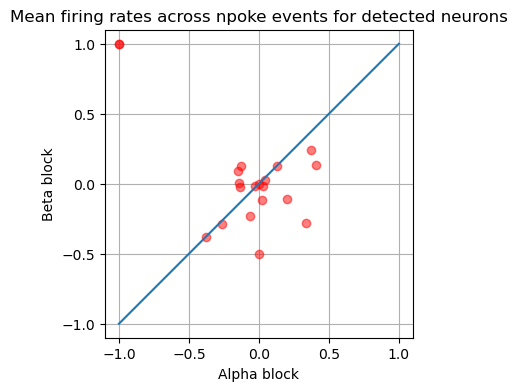

In [ ]:
plot_norm_dotes(firingrate_means_1_norm, firingrate_means_2_norm) #A1B1

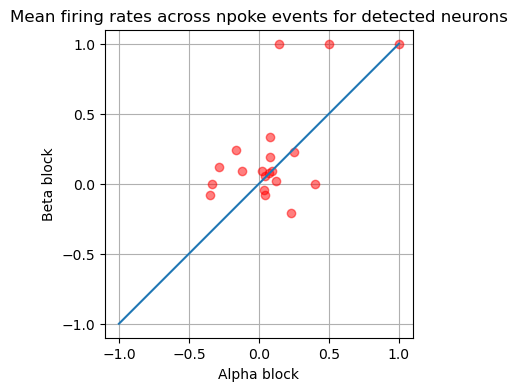

In [ ]:
plot_norm_dotes(firingrate_means_4_norm, firingrate_means_5_norm) #A2B2

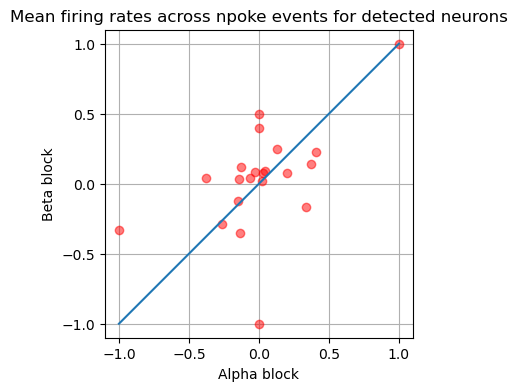

In [ ]:
plot_norm_dotes(firingrate_means_1_norm, firingrate_means_4_norm) #AA

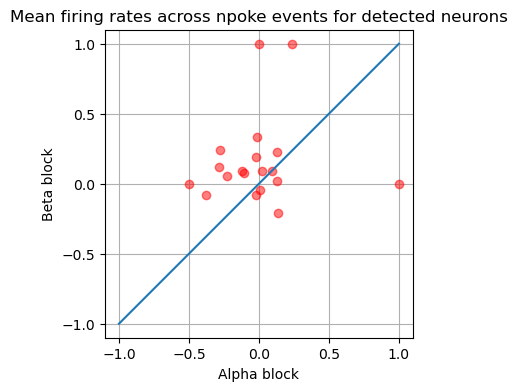

In [ ]:
plot_norm_dotes(firingrate_means_2_norm, firingrate_means_5_norm) #BB

In [ ]:
a = np.array([[81, 88, 80, 89, 83, 86, 82, 87, 85, 84],[91, 68, 90, 66, 93, 65, 92, 64, 95, 94],[69, 75, 70, 79, 72, 78, 73, 77, 74, 76],[48, 51, 50, 49, 71, 59, 67, 56, 61, 54],[58, 37, 60, 36, 63, 35, 62, 34, 32, 33],[38, 47, 39, 46, 40, 45, 41, 44, 42, 43]])
#, 57, 55, 53, 52],

In [ ]:
a-32


array([[49, 56, 48, 57, 51, 54, 50, 55, 53, 52],
       [59, 36, 58, 34, 61, 33, 60, 32, 63, 62],
       [37, 43, 38, 47, 40, 46, 41, 45, 42, 44],
       [16, 19, 18, 17, 39, 27, 35, 24, 29, 22],
       [26,  5, 28,  4, 31,  3, 30,  2,  0,  1],
       [ 6, 15,  7, 14,  8, 13,  9, 12, 10, 11]])